# Metagenomic Read Classification

This notebook shows how to predict the taxonomy of metagenomic reads with neural networks. They work
as follows:

- The input of the models, `x`, is a sequence of symbols comprised within the set `{A, C, G, T}`.
  The input is provided to the models as a one-hot encoded vector or a sequence of tokens, depending
  on the architecture.
- The target of the models, `y`, is an integer indicating a class. The models output a logit vector
  and the class is predicted as the index containing the maximum value.

This notebook uses two datasets to train models with different types of data.

# 1. Short Sequence (1500 nt) Non-Original Dataset: BERTax

This section uses data curated by BERTax (https://www.pnas.org/doi/10.1073/pnas.2122636119)
to facilitate comparison with other metagenomic classification tools. You have to download the
following datasets from https://osf.io/qg6mv/:

- `pretraining_dataset.zip`: used to pretrain NLP-based models.
- `final_model_dataset.zip`: training and evaluation dataset for all models.

In [1]:
print("Defining values to parametrize the rest of the section.")

# Directory in which all data are to be written.
DATA_DIRECTORY = "../data/"

# Directory in which the "final" BERTax dataset is to be installed.
BERTAX_FINAL_DIRECTORY = DATA_DIRECTORY + "bertax/final/"

# Directory in which the "pretraining" BERTax dataset is to be installed.
BERTAX_PRETRAINING_DIRECTORY = DATA_DIRECTORY + "bertax/pretraining/"

# Number of samples in each taxon in the test set. We use exactly the same number of samples for
# each genus that BERTax uses.
BERTAX_N_TEST_READ_PER_TAXON = 2000

# BERTax filters out genera with less than 10_000 samples, which yields 155 genera. We exclude reads
# comprising indeterminate nucleotides (i.e. "N") whereas BERTax includes them and we exclude reads
# whose taxonomy cannot be resolved from the NCBI taxonomy database. Thus, we end up with slightly
# fewer samples than BERTax. Therefore, we filter out genera with less than 9836 samples instead of
# 10000. This results in 155 genera. We always include 2000 samples per taxon in the test set.
GENUS_MINIMUM_N_READS_PER_TAXON = 9_836

# Similarly to the number of samples for each genus, we modify the minimum number of reads for each
# phylum. BERTax sets a minimum of 10000, but using 16800 ensures that we also obtain 43 phyla.
# Counting the "other" class for phyla that contain fewer reads, we obtain 44 classes. We always
# include 2000 samples per taxon in the test set.
PHYLUM_MINIMUM_N_READS_PER_TAXON = 16800

# This parameter avoids unbalancing the dataset by capping the number of samples for each class to
# this value. If we don't cap them, the "other" class (i.e. samples not belonging to the 155
# retained genera) is significantly bigger. This DOES NOT affect the composition of the test set;
# the test set is balanced exactly like in the BERTax paper.
MAX_NUMBER_OF_READS_PER_CLASS = 100_000

# Length of all samples in all BERTax datasets.
BERTAX_READ_LENGTH = 1500

# Filepaths inside of the BERTax directories.
BERTAX_DATASET_DIRECTORY = BERTAX_FINAL_DIRECTORY + "final_model_data_seperate_fasta_per_superkingdom/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80_big/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)

# Directories to store processed data.
BERTAX_VERSION_1 = BERTAX_FINAL_DIRECTORY + "version1/"
BERTAX_PHYLUM = BERTAX_VERSION_1 + "phylum/"
BERTAX_CLASS = BERTAX_VERSION_1 + "class/"
BERTAX_GENUS = BERTAX_VERSION_1 + "genus/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
PROCESSED_PRETRAINING_DATA = BERTAX_PRETRAINING_DIRECTORY + "processed/"
BERTAX_STATISTIC_DIRECTORY = BERTAX_VERSION_1 + "statistics/"
TRAINED_MODELS = "trained_models/"
BERTAX_MODELS = TRAINED_MODELS + "bertax_comparison/"

Defining values to parametrize the rest of the section.


In [2]:
print("Importing modules and defining utility functions.")
import os
import json
import random
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np
import torch
from stelaro.data import (
    ncbi,
    format,
    get_mappings,
)
from stelaro import models


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)

Importing modules and defining utility functions.


In [ ]:
print("Configuring the environment.")
mkdir(DATA_DIRECTORY)
mkdir(NCBI_TAXONOMY_DIRECTORY)
mkdir(PROCESSED_PRETRAINING_DATA)
mkdir(BERTAX_VERSION_1)
mkdir(BERTAX_STATISTIC_DIRECTORY)
mkdir(BERTAX_PHYLUM)
mkdir(BERTAX_CLASS)
mkdir(BERTAX_GENUS)
mkdir(TRAINED_MODELS)
mkdir(BERTAX_MODELS)

Configuring the environment.


## 1.1. Obtain Data

In [ ]:
ncbi.install_taxonomy(NCBI_TAXONOMY_DIRECTORY)

In [3]:
tax_ids = set()
n_reads = 0
for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                tax_ids.add(tax_id)
                n_reads += 1
print(f"Out of {n_reads} reads, found {len(tax_ids)} taxonomic identifiers.")
parents, ranks = ncbi.get_all_taxonomy_parents(
    NCBI_TAXONOMY_DIRECTORY + "nodes.dmp",
    NCBI_TAXONOMY_DIRECTORY + "merged.dmp",
)
print("Retrieving names from taxonomic identifiers.")
names = ncbi.taxid_to_names(NCBI_TAXONOMY_DIRECTORY + "names.dmp", set(parents.keys()))
print(f"Found {len(names)} in total.")
print("Resolving the taxonomy.")
lineages = ncbi.resolve_taxonomy(parents, ranks, tax_ids, names)

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.
Out of 5399920 reads, found 5837 taxonomic identifiers.
Retrieving names from taxonomic identifiers.
Found 2677441 in total.
Resolving the taxonomy.
Taxon 1546149 is nameless.
Taxon 499556 is nameless.
Taxon 46919 is nameless.
Taxon 63330 is nameless.
Taxon 45220 is nameless.
Taxon 1385592 is nameless.
Taxon 883876 is nameless.
Taxon 1980467 is nameless.
Taxon 1114980 is nameless.
Taxon 1980527 is nameless.
Taxon 1653479 is nameless.
Taxon 2169993 is nameless.
Taxon 1660064 is nameless.
Taxon 1547445 is nameless.
Taxon 31604 is nameless.
Taxon 237610 is nameless.
Taxon 1980490 is nameless.
Taxon 208899 is nameless.
Taxon 1980612 is nameless.
Taxon 1490026 is nameless.
Taxon 1980520 is nameless.
Taxon 1980464 is nameless.
Taxon 1673076 is nameless.
Taxon 656024 is nameless.
Taxon 11623 is nameless.
Taxon 640511 is nameless.
Taxon 192848 is nameless.
Taxon 62928 

In [4]:
taxa = get_mappings(tax_ids, (0, 1), lineages)
# taxa = get_mappings(tax_ids, (0, 1, 5), lineages)
print(f"Grouped taxonomic identifiers into {len(taxa)} taxa.")

Mapped 5829 / 5837 taxonomic identifiers.
Grouped taxonomic identifiers into 57 taxa.


In [5]:
counts = {key: 0 for key in taxa}
lookup_table = {}
for taxon, identifiers in taxa.items():
    for identifier in identifiers:
        if identifier in lookup_table:
            raise RuntimeError(f"`{identifier} duplicated.")
        lookup_table[identifier] = taxon

for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        current_taxon = None
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                if tax_id in lookup_table:
                    taxon = lookup_table[tax_id]
                    counts[taxon] += 1

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.


In [6]:
groupings = []
for level in range(len(list(counts.keys())[0])):
    grouping = {}
    for taxon, read_count in counts.items():
        taxon_level = taxon[:level + 1]
        if taxon_level in grouping:
            grouping[taxon_level] += read_count
        else:
            grouping[taxon_level] = read_count
    groupings.append(grouping)

In [7]:
def select_groups(grouping, cutoff) -> dict:
    selected_grouping = {("unknown", ): 0}
    for taxon, read_count in grouping.items():
        if read_count >= cutoff:
            selected_grouping[taxon] = read_count
        else:
            selected_grouping[("unknown", )] += read_count
    return selected_grouping


# class_grouping = select_groups(groupings[2], 0)
# domain_grouping = select_groups(groupings[0], 0)
phylum_grouping = select_groups(groupings[1], PHYLUM_MINIMUM_N_READS_PER_TAXON)
# genus_grouping = select_groups(groupings[2], GENUS_MINIMUM_N_READS_PER_TAXON)

In [8]:
def write_indices(grouping, level, dst) -> None:
    index = {}
    for taxon in sorted(grouping):
        index[len(index)] = list(taxon)
    with open(dst + level + "_indices.json", "w") as file:
        json.dump(index, file, indent=4)
    counts = {}
    for taxon in sorted(grouping):
        counts[str(taxon)] = grouping[taxon]
    with open(dst + level + "_counts.json", "w") as file:
        json.dump(counts, file, indent=4)


# write_indices(class_grouping, "class", BERTAX_STATISTIC_DIRECTORY)
write_indices(phylum_grouping, "phylum", BERTAX_STATISTIC_DIRECTORY)
# write_indices(domain_grouping, "domain", BERTAX_STATISTIC_DIRECTORY)
# write_indices(genus_grouping, "genus", BERTAX_STATISTIC_DIRECTORY)

In [58]:
with open(BERTAX_STATISTIC_DIRECTORY + "phylum_counts.json") as file:
    counts = json.load(file)
cleaned_class_grouping = {('unknown',): 0}
for order, count in class_grouping.items():
    if str(order[:-1]) in counts:
        cleaned_class_grouping[order] = count
    else:
        cleaned_class_grouping[('unknown',)] += count

write_indices(cleaned_class_grouping, "class", BERTAX_STATISTIC_DIRECTORY)

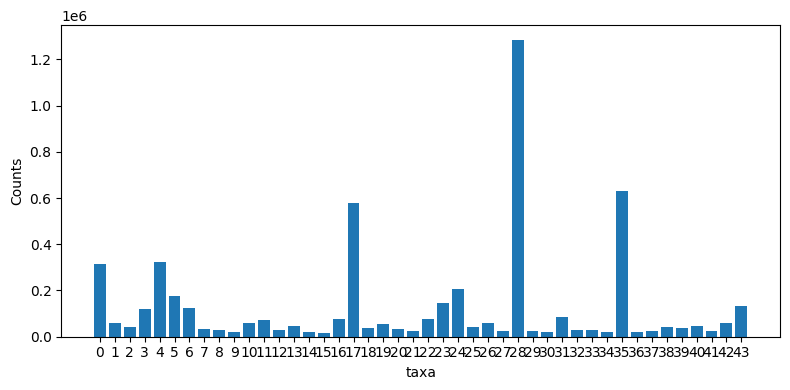

In [9]:
import matplotlib.pyplot as plt

def plot_dict_bar(data: dict):
    counts = {}
    index = 0
    for taxon in sorted(data):
        counts[str(index)] = data[taxon]
        index += 1
    keys = list(counts.keys())
    counts = list(counts.values())
    plt.figure(figsize=(8, 4))
    plt.bar(keys, counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


# plot_dict_bar(cleaned_class_grouping)
# plot_dict_bar(domain_grouping)
plot_dict_bar(phylum_grouping)
# plot_dict_bar(genus_grouping)


In [10]:
random.seed(7)


def prepare_datasets(
        mapping: dict,
        n_test: int,
        n_max_training: int,
        validation_fraction: float,
        dst: str
        ) -> tuple:
    """Split read IDs into test, train, and validation sets.

    Args:
        mapping: Map an index to a taxonomy.
        n_test: Number of reads for each taxon in the test set.
        validation_fraction: Fraction of non-test data used for validation.
        dst: Save directory.
    """
    taxon_to_read_IDs = {k: [] for k in mapping}
    reversed_mapping = {tuple(v): k for k, v in mapping.items()}
    granularity = len(mapping["0"])
    # Count reads in each taxon.
    i = 0
    for domain in BERTAX_DOMAINS:
        print(f"Inspecting `{domain}`.")
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_ID = None
            for line in tqdm(f):
                if line.startswith(">"):
                    tax_id = line.strip()
                    tax_id = tax_id.replace(">", "")
                    tax_id = tax_id.split(" ")[0]
                    if tax_id in lookup_table:
                        current_taxon = lookup_table[tax_id][:granularity]
                        if current_taxon in reversed_mapping:
                            current_ID = reversed_mapping[current_taxon]
                        else:
                            current_ID = reversed_mapping[("unknown", )]
                elif current_ID:
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        taxon_to_read_IDs[current_ID].append(i)
                        i += 1
    # Split reads into distinct sets.
    train = {k: [] for k in mapping}
    validation = {k: [] for k in mapping}
    test = {k: [] for k in mapping}
    for taxon in taxon_to_read_IDs:
        random.shuffle(taxon_to_read_IDs[taxon])
        test[taxon] = taxon_to_read_IDs[taxon][:n_test]
        if len(taxon_to_read_IDs[taxon]) > n_max_training:
            train_data = taxon_to_read_IDs[taxon][n_test:n_test + n_max_training]
        else:
            train_data = taxon_to_read_IDs[taxon][n_test:]
        cutoff = int(len(train_data) * validation_fraction)
        train[taxon] = train_data[cutoff:]
        validation[taxon] = train_data[:cutoff]
    # Generate data.
    for name, data in zip(("test", "train", "validate"), (test, train, validation)):
        print(f"{name} set.")
        elements = set()
        for indices in data.values():
            elements.update(indices)
        N = sum([len(v) for v in data.values()])
        with tqdm(total=N) as progress_bar:
            assert N == len(elements), "Unexpected counts."
            x = np.zeros((N, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
            y = np.zeros(N, dtype=np.uint16)
            i = 0
            local_i = 0
            for domain in BERTAX_DOMAINS:
                with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
                    current_ID = None
                    for line in tqdm(f):
                        if line.startswith(">"):
                            tax_id = line.strip()
                            tax_id = tax_id.replace(">", "")
                            tax_id = tax_id.split(" ")[0]
                            if tax_id in lookup_table:
                                current_taxon = lookup_table[tax_id][:granularity]
                                if current_taxon in reversed_mapping:
                                    current_ID = reversed_mapping[current_taxon]
                                else:
                                    current_ID = reversed_mapping[("unknown", )]
                        elif current_ID:
                            sequence = line.strip().upper()
                            characters = set(sequence)
                            if len(characters) == 4:
                                if i in elements:
                                    encoding = format.encode_tetramer(sequence)
                                    x[local_i] = encoding
                                    y[local_i] = int(current_ID)
                                    local_i += 1
                                    elements.remove(i)
                                i += 1
                                progress_bar.update(1)
            assert local_i == N
            mkdir(dst + name)
            np.save(dst + name + "/x.npy", x)
            np.save(dst + name + "/y.npy", y)

In [ ]:
with open(BERTAX_STATISTIC_DIRECTORY + "genus_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, MAX_NUMBER_OF_READS_PER_CLASS, 0.05, BERTAX_GENUS)

In [11]:
with open(BERTAX_STATISTIC_DIRECTORY + "phylum_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, 500_000, 0.05, BERTAX_PHYLUM)

Inspecting `Archaea_db.fa`.


0it [00:00, ?it/s]

1070306it [00:37, 28883.52it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:10, 29254.38it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [03:05, 29134.29it/s]


Inspecting `Viruses_db.fa`.


507606it [00:17, 28997.71it/s]


test set.


1070306it [00:40, 26750.40it/s]                         
3806366it [02:21, 26952.00it/s]
5415562it [03:16, 27604.59it/s]
507606it [00:20, 24986.31it/s]]
5388074it [06:37, 13540.22it/s]


train set.


1070306it [02:13, 8031.10it/s]9 [02:13<15:17, 3874.05it/s]
3806366it [07:41, 8255.95it/s]09 [09:54<07:29, 3674.42it/s]
5415562it [08:35, 10499.61it/s]                            
507606it [01:00, 8452.96it/s]]
5388074it [19:42, 4558.06it/s]


validate set.


1070306it [00:47, 22705.12it/s]                           
3806366it [02:31, 25075.55it/s]
5415562it [03:25, 26314.46it/s]
507606it [00:19, 25621.14it/s]]
5388074it [07:05, 12669.64it/s]


In [67]:
random.seed(7)


def prepare_datasets(
        mapping: dict,
        n_test: int,
        n_max_training: int,
        validation_fraction: float,
        dst: str,
        test_level: int
        ) -> tuple:
    """Split read IDs into test, train, and validation sets.

    Args:
        mapping: Map an index to a taxonomy.
        n_test: Number of reads for each taxon in the test set.
        validation_fraction: Fraction of non-test data used for validation.
        dst: Save directory.
    """
    taxon_to_read_IDs = {k: [] for k in mapping}
    reversed_mapping = {tuple(v): k for k, v in mapping.items()}
    granularity = len(mapping["0"])
    test_levels = {}
    # Count reads in each taxon.
    i = 0
    for domain in BERTAX_DOMAINS:
        print(f"Inspecting `{domain}`.")
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_ID = None
            for line in tqdm(f):
                if line.startswith(">"):
                    tax_id = line.strip()
                    tax_id = tax_id.replace(">", "")
                    tax_id = tax_id.split(" ")[0]
                    if tax_id in lookup_table:
                        current_taxon = lookup_table[tax_id][:granularity]
                        test_taxon = current_taxon[test_level]
                        if current_taxon in reversed_mapping:
                            current_ID = reversed_mapping[current_taxon]
                            if test_taxon in test_levels:
                                test_levels[test_taxon] += 1
                            else:
                                test_levels[test_taxon] = 1
                        else:
                            current_ID = reversed_mapping[("unknown", )]
                elif current_ID:
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        taxon_to_read_IDs[current_ID].append(i)
                        i += 1
    # Split reads into distinct sets.
    train = {k: [] for k in mapping}
    validation = {k: [] for k in mapping}
    test = {k: [] for k in mapping}
    for taxon in taxon_to_read_IDs:
        full_taxonomy = mapping[str(taxon)]
        if len(full_taxonomy) > 1:
            test_taxon = full_taxonomy[test_level]
            n_test_reads = int(n_test * (len(taxon_to_read_IDs[taxon]) / test_levels[test_taxon]))
        else:
            n_test_reads = n_test
        print(taxon, len(taxon_to_read_IDs[taxon]), "test", n_test_reads)
        random.shuffle(taxon_to_read_IDs[taxon])
        test[taxon] = taxon_to_read_IDs[taxon][:n_test_reads]
        if len(taxon_to_read_IDs[taxon]) > n_max_training:
            train_data = taxon_to_read_IDs[taxon][n_test_reads:n_test_reads + n_max_training]
        else:
            train_data = taxon_to_read_IDs[taxon][n_test_reads:]
        cutoff = int(len(train_data) * validation_fraction)
        train[taxon] = train_data[cutoff:]
        validation[taxon] = train_data[:cutoff]
    # Generate data.
    for name, data in zip(("test", "train", "validate"), (test, train, validation)):
        print(f"{name} set.")
        elements = set()
        for indices in data.values():
            elements.update(indices)
        N = sum([len(v) for v in data.values()])
        with tqdm(total=N) as progress_bar:
            assert N == len(elements), "Unexpected counts."
            x = np.zeros((N, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
            y = np.zeros(N, dtype=np.uint16)
            i = 0
            local_i = 0
            for domain in BERTAX_DOMAINS:
                with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
                    current_ID = None
                    for line in tqdm(f):
                        if line.startswith(">"):
                            tax_id = line.strip()
                            tax_id = tax_id.replace(">", "")
                            tax_id = tax_id.split(" ")[0]
                            if tax_id in lookup_table:
                                current_taxon = lookup_table[tax_id][:granularity]
                                if current_taxon in reversed_mapping:
                                    current_ID = reversed_mapping[current_taxon]
                                else:
                                    current_ID = reversed_mapping[("unknown", )]
                        elif current_ID:
                            sequence = line.strip().upper()
                            characters = set(sequence)
                            if len(characters) == 4:
                                if i in elements:
                                    encoding = format.encode_tetramer(sequence)
                                    x[local_i] = encoding
                                    y[local_i] = int(current_ID)
                                    local_i += 1
                                    elements.remove(i)
                                i += 1
                                progress_bar.update(1)
            assert local_i == N
            mkdir(dst + name)
            np.save(dst + name + "/x.npy", x)
            np.save(dst + name + "/y.npy", y)


with open(BERTAX_STATISTIC_DIRECTORY + "class_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, 400_000, 0.05, BERTAX_CLASS, 1)

Inspecting `Archaea_db.fa`.


0it [00:00, ?it/s]

1070306it [00:33, 31808.88it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:02, 31139.23it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [02:52, 31389.58it/s]


Inspecting `Viruses_db.fa`.


507606it [00:16, 31562.48it/s]


0 22986 test 147
1 95001 test 608
2 32205 test 206
3 26254 test 168
4 86236 test 551
5 13318 test 85
6 36457 test 233
7 59890 test 2000
8 41128 test 2000
9 121632 test 1999
10 255225 test 1573
11 33207 test 204
12 33341 test 205
13 10267 test 63
14 44363 test 512
15 47608 test 549
16 16695 test 192
17 10318 test 119
18 41756 test 482
19 16524 test 190
20 39580 test 642
21 20713 test 336
22 20709 test 336
23 23170 test 376
24 21916 test 355
25 14309 test 829
26 11652 test 675
27 9294 test 538
28 29233 test 2046
29 23032 test 2049
30 13644 test 460
31 10324 test 348
32 11863 test 400
33 10042 test 339
34 14834 test 501
35 72710 test 2047
36 30022 test 2046
37 31911 test 2045
38 16058 test 2040
39 17217 test 2043
40 10709 test 286
41 11748 test 314
42 54097 test 1447
43 11308 test 39
44 142785 test 495
45 83639 test 290
46 10919 test 37
47 333552 test 1156
48 7925 test 27
49 37233 test 2046
50 10972 test 385
51 4492 test 157
52 15773 test 553
53 18618 test 653
54 8413 test 295
55 33452 te

1070306it [00:37, 28899.19it/s]                         
3806366it [02:14, 28347.09it/s]
5415562it [03:02, 29691.84it/s]
507606it [00:19, 26330.49it/s]]
5388074it [06:13, 14426.05it/s]


train set.


1070306it [02:12, 8105.25it/s]2 [02:12<17:27, 3873.71it/s]
3806366it [07:47, 8136.83it/s]02 [09:59<08:55, 4027.48it/s]
5415562it [09:38, 9362.47it/s]                             
507606it [01:00, 8321.99it/s]]
5388074it [21:01, 4272.15it/s]


validate set.


1070306it [00:44, 24304.92it/s]                           
3806366it [02:23, 26581.67it/s]
5415562it [03:15, 27699.81it/s]
507606it [00:18, 26891.61it/s]]
5388074it [06:42, 13391.30it/s]


In [ ]:
total = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
    print(f"Domain: {domain}. Total: {total}")

x = np.zeros((total, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
i = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if not line.startswith(">"):
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    encoding = format.encode_tetramer(sequence)
                    x[i] = encoding
                    i += 1
np.save(PROCESSED_PRETRAINING_DATA + "/x.npy", x)

## 1.2. Validate Data

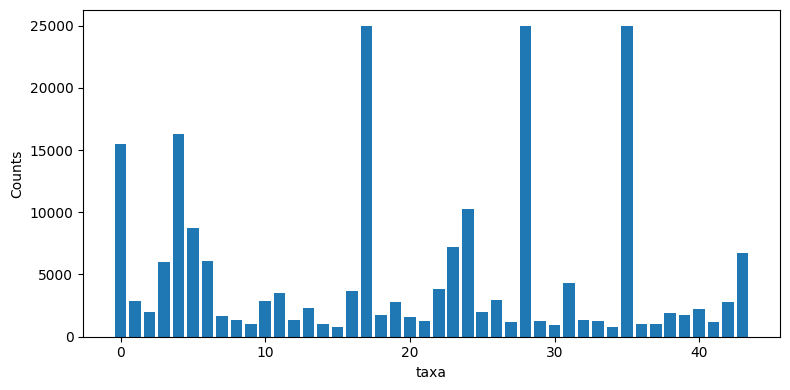

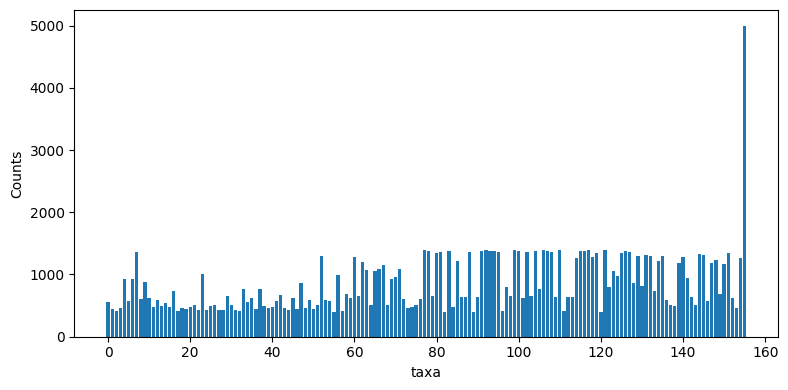

In [12]:
def plot_dict_bar(path: dict):
    y = np.load(path + "validate/y.npy")
    _, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(list(range(len(counts))), counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


plot_dict_bar(BERTAX_PHYLUM)
plot_dict_bar(BERTAX_GENUS)

## 1.3. Train Classification Models

### 1.3.1. Load Data

In [3]:
import numpy as np
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch import save, load, nn
import time


def load_data(
        classification_dir: str,
        mapping_filepath: str,
        pretraining_dir: str = None,
        batch_size: int = 128,
        ):
    train_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "train/"),
        batch_size=batch_size,
        shuffle=True
    )
    validation_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "validate/"),
        batch_size=batch_size,
        shuffle=True
    )
    test_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "test/"),
        batch_size=batch_size,
        shuffle=True
    )
    with open(mapping_filepath, "r") as f:
        mapping = json.load(f)
    if pretraining_dir:
        pretraining_data = DataLoader(
            models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
            batch_size=batch_size,
            shuffle=True
        )
    else:
        pretraining_data = False
    return train_data, validation_data, test_data, mapping, pretraining_data


def pretrain(classifier, cache_directory: str, n_steps: int, pretraining_data) -> None:
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    losses = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=n_steps,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="mlm"
    )
    print(f"Training losses: {losses}")
    save(classifier.model.state_dict(), f"{cache_directory}pretrain_mlm_weights_{n_steps // 1000}k_steps.pt2")


def train_classifier(
        classifier, cache_directory: str, epochs: tuple[int], train_data, validation_data
    ) -> None:
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    losses, validation_losses, f1, p = [], [], [], []
    for epoch in epochs:
        print(f"Epoch {epoch}")
        losses_, validation_losses_, f1_, p_ = classifier.train(
            train_data,
            validation_data,
            optimizer,
            max_n_epochs=1,
            patience=200,
            loss_function=nn.CrossEntropyLoss(),
            loss_function_type="supervised",
            evaluation_interval=10_000,
            evaluation_maximum_duration=30.0,
            patience_interval=10_000,
            n_max_steps=100_000
        )
        print(f"Training losses: {losses_}")
        print(f"Validation losses: {validation_losses_}")
        print(f"F1 scores: {f1_}")
        print(f"Precisions: {p_}")
        losses += losses_
        validation_losses += validation_losses_
        f1 += f1_
        p += p_
        save(classifier.model.state_dict(), f"{cache_directory}weights_{epoch}_epoch.pt2")

    print(f"Training losses: {losses}")
    print(f"Validation losses: {validation_losses}")
    print(f"F1 scores: {f1}")
    print(f"Precisions: {p}")


def test_speed(classifier, N):
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    a = time.time()
    classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=N * 2,
        evaluation_maximum_duration=30.0,
        patience_interval=N * 2,
        n_max_steps=N
    )
    delta = time.time() - a
    average = delta / N
    print(f"Average time for {N} steps: {average}.")


# train_data, validation_data, test_data, mapping, pretraining_data = load_data(
#     BERTAX_GENUS,
#     BERTAX_STATISTIC_DIRECTORY + "genus_indices.json",
#     BERTAX_PRETRAINING_DIRECTORY,
#     128
# )

train_data, validation_data, test_data, mapping, pretraining_data = load_data(
    BERTAX_PHYLUM,
    BERTAX_STATISTIC_DIRECTORY + "phylum_indices.json",
    BERTAX_PRETRAINING_DIRECTORY,
    64
)

### 1.3.2. Test Models

#### 1.3.2.1. Mamba From Scratch

Number of parameters: 1_005_869
Epoch 5


 16%|█▌        | 5000/31944 [23:42<2:10:25,  3.44it/s] 

Halting evaluation after 41984 data points.
Halting evaluation after 42496 data points.


 16%|█▌        | 5002/31944 [25:20<153:39:21, 20.53s/it]

Halting evaluation after 45568 data points.
1/1 F1: [0.94465, 0.91375]. Precision: [0.95076, 0.92693] 
Training loss: 77.78583. Validation loss: 95.60491. Patience: 200


 31%|███▏      | 10000/31944 [47:58<1:37:18,  3.76it/s] 

Halting evaluation after 48512 data points.
Halting evaluation after 48512 data points.


 31%|███▏      | 10001/31944 [49:35<178:54:39, 29.35s/it]

Halting evaluation after 48000 data points.
1/1 F1: [0.95304, 0.92066]. Precision: [0.95991, 0.9276] 
Training loss: 79.77254. Validation loss: 90.85897. Patience: 200


 47%|████▋     | 15000/31944 [1:12:26<1:15:04,  3.76it/s] 

Halting evaluation after 48512 data points.
Halting evaluation after 48640 data points.


 47%|████▋     | 15001/31944 [1:14:03<137:58:21, 29.32s/it]

Halting evaluation after 48000 data points.
1/1 F1: [0.9468, 0.92104]. Precision: [0.94963, 0.93639] 
Training loss: 79.78409. Validation loss: 92.98586. Patience: 199


 63%|██████▎   | 20000/31944 [1:36:55<52:50,  3.77it/s]    

Halting evaluation after 48640 data points.
Halting evaluation after 48512 data points.


 63%|██████▎   | 20001/31944 [1:38:32<97:26:23, 29.37s/it]

Halting evaluation after 48128 data points.
1/1 F1: [0.95205, 0.92212]. Precision: [0.96348, 0.92996] 
Training loss: 80.15048. Validation loss: 88.82589. Patience: 199


 78%|███████▊  | 25000/31944 [2:00:37<30:43,  3.77it/s]   

Halting evaluation after 48640 data points.
Halting evaluation after 48512 data points.


 78%|███████▊  | 25001/31944 [2:02:14<56:41:15, 29.39s/it]

Halting evaluation after 48384 data points.
1/1 F1: [0.95279, 0.92481]. Precision: [0.95782, 0.9249] 
Training loss: 80.12623. Validation loss: 88.14308. Patience: 199


 94%|█████████▍| 30000/31944 [2:24:19<08:34,  3.78it/s]   

Halting evaluation after 49024 data points.
Halting evaluation after 48768 data points.


 94%|█████████▍| 30001/31944 [2:25:57<15:53:02, 29.43s/it]

Halting evaluation after 48000 data points.
1/1 F1: [0.95157, 0.91925]. Precision: [0.95879, 0.93263] 
Training loss: 79.96944. Validation loss: 93.35084. Patience: 198


100%|██████████| 31944/31944 [2:34:32<00:00,  3.44it/s]   


Training loss: 79.96944. Validation loss: 93.35084. Patience: 198
Maximum number of epochs reached; stopping early.
Training losses: [77.78583355983719, 79.77253947062418, 79.7840854972601, 80.1504776565358, 80.12623456399888, 79.9694365602918]
Validation losses: [95.6049057853858, 90.85897451639175, 92.98585753142834, 88.82589333076426, 88.14307595677083, 93.35084215551615]
F1 scores: [array([0.94464992, 0.95303638, 0.94680162, 0.9520503 , 0.95279325,
       0.95157049]), array([0.91375112, 0.92066225, 0.92103931, 0.92212133, 0.92480927,
       0.91924924])]
Precisions: [array([0.95075796, 0.95990531, 0.94962982, 0.96348389, 0.95781663,
       0.95879469]), array([0.92692848, 0.92760462, 0.93639115, 0.92995685, 0.9248987 ,
       0.93262612])]
Training losses: [77.78583355983719, 79.77253947062418, 79.7840854972601, 80.1504776565358, 80.12623456399888, 79.9694365602918]
Validation losses: [95.6049057853858, 90.85897451639175, 92.98585753142834, 88.82589333076426, 88.14307595677083, 93

100%|██████████| 688/688 [00:54<00:00, 12.68it/s]


F1 score: [np.float64(0.9558299001454508), np.float64(0.9213047526777057)]
Macro precision score: [np.float64(0.9763091794503593), np.float64(0.9322980734783723)]


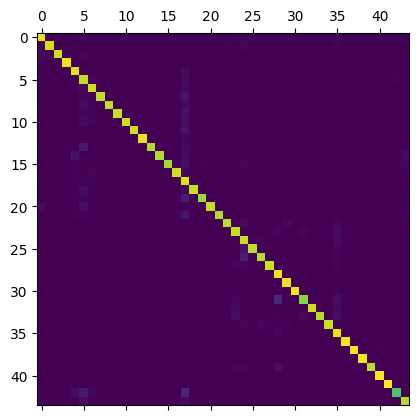

In [7]:
directory = f"{BERTAX_MODELS}phylum_mamba_large/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=8,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_4_epoch.pt2"))
train_classifier(classifier, directory, (5, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300, exclude_other=True)
# test_speed(classifier, 100)

#### 1.3.2.2. Mamba-Memory From Scratch

Number of parameters: 2_506_477
Epoch 3


 16%|█▌        | 5000/31944 [29:03<2:46:05,  2.70it/s] 

Halting evaluation after 30848 data points.
Halting evaluation after 36224 data points.


 16%|█▌        | 5002/31944 [30:39<152:12:26, 20.34s/it]

Halting evaluation after 35712 data points.
1/1 F1: [0.94418, 0.90449]. Precision: [0.94707, 0.90659] 
Training loss: 92.18563. Validation loss: 104.11990. Patience: 200


 31%|███▏      | 10000/31944 [1:01:43<2:01:57,  3.00it/s]

Halting evaluation after 36224 data points.
Halting evaluation after 37888 data points.


 31%|███▏      | 10002/31944 [1:03:21<125:32:19, 20.60s/it]

Halting evaluation after 37504 data points.
1/1 F1: [0.94174, 0.90474]. Precision: [0.94298, 0.91525] 
Training loss: 93.08330. Validation loss: 106.44921. Patience: 199


 47%|████▋     | 15000/31944 [1:33:59<1:51:10,  2.54it/s]  

Halting evaluation after 33152 data points.
Halting evaluation after 38272 data points.


 47%|████▋     | 15002/31944 [1:35:35<95:54:15, 20.38s/it] 

Halting evaluation after 35712 data points.
1/1 F1: [0.94567, 0.91029]. Precision: [0.95636, 0.92162] 
Training loss: 92.81859. Validation loss: 98.22201. Patience: 199


 63%|██████▎   | 20000/31944 [2:07:01<1:06:14,  3.01it/s] 

Halting evaluation after 37376 data points.
Halting evaluation after 38016 data points.


 63%|██████▎   | 20002/31944 [2:08:38<67:35:08, 20.37s/it]

Halting evaluation after 37632 data points.
1/1 F1: [0.94847, 0.91222]. Precision: [0.95625, 0.92171] 
Training loss: 91.57549. Validation loss: 100.05334. Patience: 198


 78%|███████▊  | 25000/31944 [2:40:25<42:14,  2.74it/s]   

Halting evaluation after 33024 data points.
Halting evaluation after 37120 data points.


 78%|███████▊  | 25002/31944 [2:42:01<39:16:24, 20.37s/it]

Halting evaluation after 37632 data points.
1/1 F1: [0.94623, 0.91341]. Precision: [0.95294, 0.92492] 
Training loss: 91.50803. Validation loss: 100.35522. Patience: 197


 94%|█████████▍| 30000/31944 [3:13:32<11:38,  2.78it/s]   

Halting evaluation after 33152 data points.
Halting evaluation after 38144 data points.


 94%|█████████▍| 30002/31944 [3:15:08<10:58:38, 20.35s/it]

Halting evaluation after 38016 data points.
1/1 F1: [0.94434, 0.9104]. Precision: [0.95245, 0.92534] 
Training loss: 90.64678. Validation loss: 99.68746. Patience: 196


100%|██████████| 31944/31944 [3:27:31<00:00,  2.57it/s]   


Training loss: 90.64678. Validation loss: 99.68746. Patience: 196
Maximum number of epochs reached; stopping early.
Training losses: [92.18562597138808, 93.08329999689013, 92.81859251428395, 91.57549332082272, 91.50803219061345, 90.6467765238136]
Validation losses: [104.11990459968327, 106.44921095590442, 98.22200737412898, 100.05333843850056, 100.3552152186024, 99.68746263496202]
F1 scores: [array([0.94418341, 0.94173525, 0.94567148, 0.9484674 , 0.94622832,
       0.9443428 ]), array([0.90448598, 0.90473535, 0.91029235, 0.9122219 , 0.91341371,
       0.91040034])]
Precisions: [array([0.94706547, 0.94298295, 0.95636498, 0.95624664, 0.95294272,
       0.95245433]), array([0.90658871, 0.91525224, 0.92162144, 0.92171457, 0.92491924,
       0.92533669])]
Training losses: [92.18562597138808, 93.08329999689013, 92.81859251428395, 91.57549332082272, 91.50803219061345, 90.6467765238136]
Validation losses: [104.11990459968327, 106.44921095590442, 98.22200737412898, 100.05333843850056, 100.35521

100%|██████████| 688/688 [01:18<00:00,  8.75it/s]


F1 score: [np.float64(0.9476059430898849), np.float64(0.9115434088025327)]
Macro precision score: [np.float64(0.9712966523835953), np.float64(0.9247322664637808)]


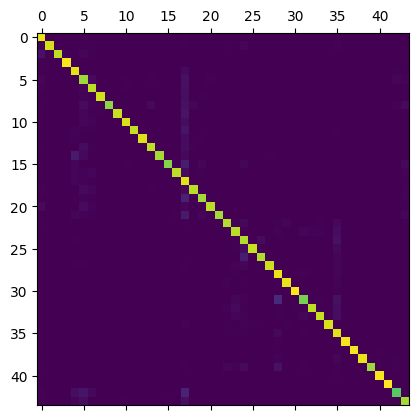

In [7]:
directory = f"{BERTAX_MODELS}phylum_mamba_memory_experimental/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=192,
        n_layers=6,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_2_epoch.pt2"))
train_classifier(classifier, directory, (3, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300, exclude_other=True)

#### 1.3.2.3. Encoder-Only Transformer From Scratch

In [ ]:
directory = f"{BERTAX_MODELS}transformer/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)

# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.4. Pretrainined Mamba

MLM

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
# pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
classifier.model.load_state_dict(load(f"{directory}/20k_mlm/weights_80k_steps.pt2"))
train_classifier(classifier, f"{directory}/20k_mlm/", (5, 6, 7, 8, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

In [ ]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Causal

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses = []
# classifier.model.load_state_dict(load(f"{directory}pretrain_causal_weights_20k_steps.pt2"))
for total_n_steps in (20, 40, ):
    losses_ = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=20_000,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="causal"
    )
    print(f"Training losses: {losses_}")
    losses += losses_
    save(classifier.model.state_dict(), f"{directory}pretrain_causal_weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/20k_causal/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_causal_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)

In [ ]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.5. Pretrainined Mamba-Memory

In [ ]:
directory = f"{BERTAX_MODELS}mamba_memory_experimental/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.6. Pretrained Encoder-Only Transformer

In [ ]:
directory = f"{BERTAX_MODELS}transformer_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.7. Mamba from Scratch, 3-mer

In [ ]:
directory = f"{BERTAX_MODELS}mamba_3mer/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=64,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_codons,
    True
)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
test_speed(classifier, 100)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of parameters: 504_029
Epoch 1


 25%|██▍       | 5000/20040 [15:54<47:46,  5.25it/s]  

Halting evaluation after 76416 data points.
Halting evaluation after 76928 data points.


 25%|██▍       | 5001/20040 [17:44<138:10:19, 33.08s/it]

Halting evaluation after 76416 data points.
1/1 F1: [0.77355, 0.78361, 0.51624]. Precision: [0.77432, 0.77821, 0.55476] 
Training loss: 896.78181. Validation loss: 695.02849. Patience: 200


 50%|████▉     | 10000/20040 [34:27<32:06,  5.21it/s]   

Halting evaluation after 76800 data points.
Halting evaluation after 77312 data points.


 50%|████▉     | 10001/20040 [36:17<92:02:32, 33.01s/it]

Halting evaluation after 76032 data points.
1/1 F1: [0.81015, 0.8389, 0.58497]. Precision: [0.81743, 0.84605, 0.62259] 
Training loss: 640.89182. Validation loss: 592.41845. Patience: 200


 75%|███████▍  | 15000/20040 [52:12<16:04,  5.23it/s]   

Halting evaluation after 76544 data points.
Halting evaluation after 77184 data points.


 75%|███████▍  | 15001/20040 [53:58<45:01:13, 32.16s/it]

Halting evaluation after 76032 data points.
1/1 F1: [0.82198, 0.85587, 0.61287]. Precision: [0.83156, 0.86421, 0.65447] 
Training loss: 570.10031. Validation loss: 548.26540. Patience: 200


100%|█████████▉| 20000/20040 [1:11:26<00:07,  5.23it/s]  

Halting evaluation after 77312 data points.
Halting evaluation after 77568 data points.


100%|█████████▉| 20001/20040 [1:13:13<21:04, 32.42s/it]

Halting evaluation after 76032 data points.
1/1 F1: [0.82176, 0.86781, 0.63832]. Precision: [0.83132, 0.8712, 0.66325] 
Training loss: 530.81769. Validation loss: 515.35480. Patience: 200


100%|██████████| 20040/20040 [1:13:21<00:00,  4.55it/s]


Training loss: 530.81769. Validation loss: 515.35480. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [896.7818147510291, 640.8918185502291, 570.1003104329109, 530.8176860958338]
Validation losses: [695.0284916551868, 592.4184545874596, 548.265397247642, 515.3547959270501]
F1 scores: [array([0.77355321, 0.81015057, 0.8219808 , 0.82176042]), array([0.7836119 , 0.83889831, 0.8558715 , 0.86781133]), array([0.51624253, 0.58496544, 0.61287202, 0.63831749])]
Precisions: [array([0.77431608, 0.81743393, 0.83155699, 0.83131848]), array([0.77821306, 0.8460487 , 0.86421274, 0.87119954]), array([0.55476144, 0.62258803, 0.65446875, 0.6632516 ])]
Epoch 2


 25%|██▍       | 5000/20040 [15:56<47:54,  5.23it/s]  

Halting evaluation after 77440 data points.
Halting evaluation after 77568 data points.


 25%|██▍       | 5001/20040 [17:44<136:01:14, 32.56s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.83692, 0.88013, 0.65247]. Precision: [0.83974, 0.8916, 0.6896] 
Training loss: 499.45543. Validation loss: 498.99619. Patience: 200


 50%|████▉     | 10000/20040 [35:12<31:55,  5.24it/s]   

Halting evaluation after 76800 data points.
Halting evaluation after 76928 data points.


 50%|████▉     | 10001/20040 [36:59<89:50:29, 32.22s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.83931, 0.88513, 0.66831]. Precision: [0.83514, 0.89459, 0.69891] 
Training loss: 481.52744. Validation loss: 474.53444. Patience: 200


 75%|███████▍  | 15000/20040 [54:25<16:06,  5.21it/s]   

Halting evaluation after 77056 data points.
Halting evaluation after 77056 data points.


 75%|███████▍  | 15001/20040 [56:12<45:07:05, 32.23s/it]

Halting evaluation after 76672 data points.
1/1 F1: [0.84544, 0.89003, 0.66913]. Precision: [0.84828, 0.90065, 0.69632] 
Training loss: 467.80514. Validation loss: 467.72973. Patience: 200


100%|█████████▉| 20000/20040 [1:12:07<00:07,  5.25it/s] 

Halting evaluation after 77568 data points.
Halting evaluation after 77696 data points.


100%|█████████▉| 20001/20040 [1:13:54<20:57, 32.26s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.84491, 0.89628, 0.68383]. Precision: [0.84238, 0.90776, 0.71447] 
Training loss: 456.76603. Validation loss: 454.20799. Patience: 200


100%|██████████| 20040/20040 [1:14:01<00:00,  4.51it/s]


Training loss: 456.76603. Validation loss: 454.20799. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [499.4554267957807, 481.52744264155626, 467.8051354944706, 456.7660338297486]
Validation losses: [498.9961890488111, 474.53444136791865, 467.7297289985448, 454.2079867685542]
F1 scores: [array([0.83691954, 0.83931493, 0.84543912, 0.84490675]), array([0.88013218, 0.88512992, 0.89002789, 0.89627726]), array([0.65246667, 0.66830625, 0.6691331 , 0.68382793])]
Precisions: [array([0.83974427, 0.8351439 , 0.84828139, 0.84237974]), array([0.89159609, 0.89459152, 0.9006536 , 0.90776008]), array([0.68960294, 0.69891057, 0.69631588, 0.71447422])]
Epoch 3


 25%|██▍       | 5000/20040 [15:54<48:16,  5.19it/s]  

Halting evaluation after 76928 data points.
Halting evaluation after 76928 data points.


 25%|██▍       | 5001/20040 [17:41<134:10:47, 32.12s/it]

Halting evaluation after 76160 data points.
1/1 F1: [0.85027, 0.8913, 0.68346]. Precision: [0.85786, 0.89257, 0.70968] 
Training loss: 438.77018. Validation loss: 448.50797. Patience: 200


 50%|████▉     | 10000/20040 [35:14<31:46,  5.27it/s]   

Halting evaluation after 77696 data points.
Halting evaluation after 77056 data points.


 50%|████▉     | 10001/20040 [37:01<90:02:42, 32.29s/it]

Halting evaluation after 76288 data points.
1/1 F1: [0.85065, 0.89674, 0.69197]. Precision: [0.84928, 0.90412, 0.71285] 
Training loss: 432.72491. Validation loss: 439.93050. Patience: 200


 75%|███████▍  | 15000/20040 [54:30<16:03,  5.23it/s]   

Halting evaluation after 77184 data points.
Halting evaluation after 77184 data points.


#### 1.3.2.8. Mamba-CNN

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of parameters: 1_092_652
Epoch 5


 16%|█▌        | 5000/31944 [24:23<2:08:12,  3.50it/s]

Halting evaluation after 23552 data points.
Halting evaluation after 3328 data points.


 16%|█▌        | 5001/31944 [26:00<219:19:59, 29.31s/it]

Halting evaluation after 36480 data points.
1/1 F1: [0.95266, 0.91909]. Precision: [0.96115, 0.92856] 
Training loss: 77.74808. Validation loss: 93.66596. Patience: 200


 31%|███▏      | 10000/31944 [51:00<1:52:19,  3.26it/s] 

Halting evaluation after 42240 data points.
Halting evaluation after 43392 data points.


 31%|███▏      | 10002/31944 [52:37<125:07:14, 20.53s/it]

Halting evaluation after 44160 data points.
1/1 F1: [0.95481, 0.92419]. Precision: [0.95882, 0.93532] 
Training loss: 80.04703. Validation loss: 87.70235. Patience: 200


 47%|████▋     | 15000/31944 [1:18:02<1:26:59,  3.25it/s]

Halting evaluation after 39040 data points.
Halting evaluation after 40832 data points.


 47%|████▋     | 15002/31944 [1:19:39<96:40:29, 20.54s/it] 

Halting evaluation after 39936 data points.
1/1 F1: [0.95437, 0.923]. Precision: [0.95647, 0.93372] 
Training loss: 79.91999. Validation loss: 85.17354. Patience: 200


 63%|██████▎   | 20000/31944 [1:46:27<1:04:20,  3.09it/s] 

Halting evaluation after 40704 data points.
Halting evaluation after 41984 data points.


 63%|██████▎   | 20002/31944 [1:48:05<68:23:15, 20.62s/it]

Halting evaluation after 42368 data points.
1/1 F1: [0.95452, 0.92501]. Precision: [0.96375, 0.93261] 
Training loss: 79.94860. Validation loss: 87.93339. Patience: 199


 78%|███████▊  | 25000/31944 [2:14:51<37:35,  3.08it/s]   

Halting evaluation after 36352 data points.
Halting evaluation after 40320 data points.


 78%|███████▊  | 25002/31944 [2:16:28<39:36:04, 20.54s/it]

Halting evaluation after 41472 data points.
1/1 F1: [0.95403, 0.92157]. Precision: [0.94476, 0.92526] 
Training loss: 79.95924. Validation loss: 90.47523. Patience: 198


 94%|█████████▍| 30000/31944 [2:44:01<10:27,  3.10it/s]   

Halting evaluation after 36864 data points.
Halting evaluation after 42624 data points.


 94%|█████████▍| 30002/31944 [2:45:37<11:02:59, 20.48s/it]

Halting evaluation after 44032 data points.
1/1 F1: [0.95649, 0.92635]. Precision: [0.95581, 0.934] 
Training loss: 79.72758. Validation loss: 86.17297. Patience: 197


100%|██████████| 31944/31944 [2:55:47<00:00,  3.03it/s]   


Training loss: 79.72758. Validation loss: 86.17297. Patience: 197
Maximum number of epochs reached; stopping early.
Training losses: [77.74808164956048, 80.04703173022718, 79.91998561928048, 79.9485979073681, 79.95923613701015, 79.72757903421298]
Validation losses: [93.6659563528864, 87.70235480497712, 85.1735379636431, 87.93339152536228, 90.47523273706989, 86.1729655068281]
F1 scores: [array([0.95266158, 0.95481189, 0.95436665, 0.95451946, 0.95402995,
       0.95649384]), array([0.91909301, 0.92418987, 0.92299757, 0.92501286, 0.92157358,
       0.9263462 ])]
Precisions: [array([0.96114698, 0.958818  , 0.9564658 , 0.96374575, 0.94476033,
       0.95580902]), array([0.92856015, 0.93531732, 0.93371739, 0.93260904, 0.92525916,
       0.93400026])]
Training losses: [77.74808164956048, 80.04703173022718, 79.91998561928048, 79.9485979073681, 79.95923613701015, 79.72757903421298]
Validation losses: [93.6659563528864, 87.70235480497712, 85.1735379636431, 87.93339152536228, 90.47523273706989, 8

100%|██████████| 688/688 [01:01<00:00, 11.19it/s]


F1 score: [np.float64(0.9472987100993627), np.float64(0.9212571699288564)]
Macro precision score: [np.float64(0.971681987121445), np.float64(0.9335145918146971)]


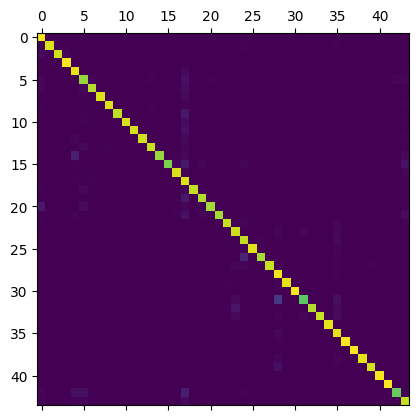

In [4]:
directory = f"{BERTAX_MODELS}phylum_mamba_cnn_large/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=8,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_4_epoch.pt2"))
train_classifier(classifier, directory, (5, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300, exclude_other=True)

#### 1.3.2.9. Mamba-Memory-CNN

Number of parameters: 4_818_220
Epoch 11


 16%|█▌        | 10000/63888 [42:02<3:38:22,  4.11it/s]

Halting evaluation after 21184 data points.
Halting evaluation after 23360 data points.


 16%|█▌        | 10002/63888 [43:36<296:47:22, 19.83s/it]

Halting evaluation after 22656 data points.
1/1 F1: [0.95327, 0.9195]. Precision: [0.95575, 0.92767] 
Training loss: 80.90217. Validation loss: 97.99349. Patience: 200


 31%|███▏      | 20000/63888 [1:24:08<2:51:55,  4.25it/s]

Halting evaluation after 24960 data points.
Halting evaluation after 24384 data points.


 31%|███▏      | 20001/63888 [1:25:41<345:02:29, 28.30s/it]

Halting evaluation after 24832 data points.
1/1 F1: [0.95482, 0.91932]. Precision: [0.9544, 0.93086] 
Training loss: 81.35210. Validation loss: 92.98970. Patience: 200


 47%|████▋     | 30000/63888 [2:04:58<2:12:36,  4.26it/s]  

Halting evaluation after 25024 data points.
Halting evaluation after 25088 data points.


 47%|████▋     | 30001/63888 [2:06:31<266:35:07, 28.32s/it]

Halting evaluation after 24896 data points.
1/1 F1: [0.95311, 0.92086]. Precision: [0.95463, 0.92939] 
Training loss: 81.40520. Validation loss: 93.72164. Patience: 199


 63%|██████▎   | 40000/63888 [2:45:38<1:33:03,  4.28it/s]  

Halting evaluation after 25088 data points.
Halting evaluation after 25088 data points.


 63%|██████▎   | 40001/63888 [2:47:12<187:43:26, 28.29s/it]

Halting evaluation after 24960 data points.
1/1 F1: [0.94964, 0.91697]. Precision: [0.95092, 0.92553] 
Training loss: 82.79492. Validation loss: 96.14068. Patience: 198


 78%|███████▊  | 50000/63888 [3:35:31<54:00,  4.29it/s]      

Halting evaluation after 25216 data points.
Halting evaluation after 25216 data points.


 78%|███████▊  | 50001/63888 [3:37:05<109:17:45, 28.33s/it]

Halting evaluation after 25024 data points.
1/1 F1: [0.95355, 0.92286]. Precision: [0.95609, 0.92879] 
Training loss: 82.33905. Validation loss: 92.67094. Patience: 198


 94%|█████████▍| 60000/63888 [4:16:14<15:11,  4.27it/s]    

Halting evaluation after 25088 data points.
Halting evaluation after 25280 data points.


 94%|█████████▍| 60001/63888 [4:17:48<30:34:29, 28.32s/it]

Halting evaluation after 25024 data points.
1/1 F1: [0.9526, 0.92344]. Precision: [0.94948, 0.92381] 
Training loss: 82.81136. Validation loss: 88.49258. Patience: 198


100%|██████████| 63888/63888 [4:32:59<00:00,  3.90it/s]   


Training loss: 82.81136. Validation loss: 88.49258. Patience: 198
Maximum number of epochs reached; stopping early.
Training losses: [80.90217490489594, 81.35209734620294, 81.40519819257315, 82.79492048635147, 82.33904537970666, 82.81135849147104]
Validation losses: [97.99348900757604, 92.9896954468634, 93.72163656261057, 96.14068439516883, 92.67093881707439, 88.49258135523066]
F1 scores: [array([0.95327161, 0.95481864, 0.95311249, 0.94964134, 0.95355465,
       0.95259884]), array([0.9194975 , 0.91932171, 0.92085552, 0.91697316, 0.92286282,
       0.92343919])]
Precisions: [array([0.95575191, 0.95440433, 0.9546278 , 0.95092399, 0.95609112,
       0.94947604]), array([0.92766619, 0.93085749, 0.92938576, 0.9255295 , 0.92878751,
       0.92380943])]
Training losses: [80.90217490489594, 81.35209734620294, 81.40519819257315, 82.79492048635147, 82.33904537970666, 82.81135849147104]
Validation losses: [97.99348900757604, 92.9896954468634, 93.72163656261057, 96.14068439516883, 92.670938817074

100%|██████████| 1375/1375 [01:46<00:00, 12.93it/s]


F1 score: [np.float64(0.9504451485154073), np.float64(0.9149733754308034)]
Macro precision score: [np.float64(0.9745854742517921), np.float64(0.927861834457048)]


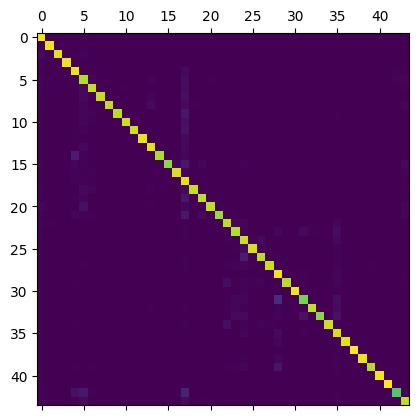

In [ ]:
directory = f"{BERTAX_MODELS}phylum_mamba_memory_cnn_experimental_large/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierMemoryCNN(
        N=None,
        num_classes=len(mapping),
        d_model=256,
        n_layers=6,
        d_state=16,
        d_conv=4,
        expand=2,
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_10_epoch.pt2"))
train_classifier(classifier, directory, (11, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 200, exclude_other=True)

# 7, MambaSequenceClassifierMemoryCNN, 128, 2, 16, 4, 2
# Training loss: 80.34423. Validation loss: 89.66190
# F1 score: [np.float64(0.9519080513519157), np.float64(0.9222734072263962)]
# Macro precision score: [np.float64(0.9753259993466953), np.float64(0.9338887638201884)]

# 4, MambaSequenceClassifierMemoryCNN, 192, 2, 16, 4, 2
# Macro precision score: np.float64(0.932)

# MambaSequenceClassifierMemoryCNN, 192, 3, 16, 4, 2
# 2: Macro precision score: [np.float64(0.9699046339860709), np.float64(0.9244013681426323)]
# 4: Macro precision score: [np.float64(0.9773689490620802), np.float64(0.9340160510653457)]

# MambaSequenceClassifierMemoryCNN, 192, 4, 16, 4, 2
# 4: Macro precision score: [np.float64(0.9790408700101819), np.float64(0.9380637641169194)]
# 5: Macro precision score: [np.float64(0.9789728658714224), np.float64(0.9389180371223507)]
# 6: Macro precision score: [np.float64(0.9799244194033627), np.float64(0.9394342184976909)]
# 7: Macro precision score: [np.float64(0.9761535206063033), np.float64(0.9399284636078156)]
# 8: Macro precision score: [np.float64(0.9788752865291148), np.float64(0.9411470872138812)]

# MambaSequenceClassifierMemoryCNN, 192, 6, 16, 4, 2
# 1: Macro precision score: [np.float64(0.9579104843673907), np.float64(0.9041699839609515)]
# 2: Macro precision score: [np.float64(0.9633247067247911), np.float64(0.9201709808963118)]
# 3: Macro precision score: [np.float64(0.9746489969816402), np.float64(0.9253100815742199)]
# 4: Macro precision score: [np.float64(0.9702579996319559), np.float64(0.9313933005411339)]
# 5: Macro precision score: [np.float64(0.9793165781302244), np.float64(0.938876153869543)]
# 6: Macro precision score: [np.float64(0.9770938902918322), np.float64(0.938420593609929)]
# 7: Macro precision score: [np.float64(0.9803070360551436), np.float64(0.9396195737478887)]
# 8: Macro precision score: [np.float64(0.9780304689063749), np.float64(0.9387842142630136)]
# 9: Macro precision score: [np.float64(0.9754969722447354), np.float64(0.9394348196613622)]
# 10: Macro precision score: [np.float64(0.9783073903790772), np.float64(0.9418004307485007)]
# 11: Macro precision score: [np.float64(0.981957837755161), np.float64(0.942543154898816)]
# 12: Macro precision score: [np.float64(0.9749506893991307), np.float64(0.9409911737409592)]
# 14: Macro precision score: [np.float64(0.9804818941615319), np.float64(0.942216083993054)]

# MambaSequenceClassifierMemoryCNN, 256, 6, 16, 4, 2
# 1: Macro precision score: [np.float64(0.9566796319898246), np.float64(0.9014757007091871)]
# 2: Macro precision score: [np.float64(0.9630301750830801), np.float64(0.9117484819081604)]
# 3: Macro precision score: [np.float64(0.9666794902771914), np.float64(0.9144518132523345)]
# 4: Macro precision score: [np.float64(0.9664245963887047), np.float64(0.9181183812764281)]
# 5: Macro precision score: [np.float64(0.9678900802530039), np.float64(0.9212850595259443)]
# 6: Macro precision score: [np.float64(0.9731635488828341), np.float64(0.9257113397216812)]
# 7: Macro precision score: [np.float64(0.9720400540320576), np.float64(0.9259738239510612)]
# 8: Macro precision score: [np.float64(0.9731519686445732), np.float64(0.9274044659369228)]
# 9: Macro precision score: [np.float64(0.9708281910014288), np.float64(0.9263717604252634)]
# 10: Macro precision score: [np.float64(0.9720586407526953), np.float64(0.9270863624096999)]
# 11: Macro precision score: [np.float64(0.9745854742517921), np.float64(0.927861834457048)]

In [5]:
save(classifier.model.state_dict(), f"{directory}weights_2_epoch.pt2")

#### 1.3.2.10. Random Forest

In [ ]:
K = 6
N_TRAINING_SAMPLES = 100_000
N_TEST_SAMPLE = 20_000


def sample(data, limit: int, formatter: any) -> tuple:
    x, y = [], []
    i = 0
    for x_batch, y_batch in tqdm(data):
        for xi, yi in zip(x_batch, y_batch):
            x.append(formatter(xi))
            y.append(yi)
            i += 1
            if limit is not None and i >= limit:
                break
        if limit is not None and i >= limit:
            break
    x = np.array(x)
    y = np.array(y)
    _, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(list(range(len(counts))), counts)
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()
    assert sum(counts) == limit
    return x, y


def kmer_counts(x: torch.Tensor, K) -> torch.Tensor:
    L = x.shape[0]
    if L < K:
        raise ValueError("Sequence length must be >= k")
    shifts = torch.tensor([6, 4, 2, 0]).view(1, 1, 4)
    x = x.unsqueeze(dim=-1)
    tokens = (x >> shifts) & 0b11
    seq = tokens.view(L * 4)
    num_kmers = 4 ** K
    base = torch.tensor([4**i for i in reversed(range(K))], device=seq.device)
    kmers = torch.stack([seq[i:i + K] for i in range(L - K + 1)], dim=0)
    kmer_ids = (kmers * base).sum(dim=-1)
    counts = torch.zeros(num_kmers, device=seq.device, dtype=torch.float32)
    counts.scatter_add_(0, kmer_ids, torch.ones_like(kmer_ids, dtype=torch.float32))
    counts = counts / counts.sum()
    return counts


x, y = sample(train_data, N_TRAINING_SAMPLES, lambda x: kmer_counts(x, K))
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    n_jobs=1,
)
rf.fit(x, y)
x_test, y_test = sample(test_data, N_TEST_SAMPLE, lambda x: kmer_counts(x, K))
y_pred = rf.predict(x_test)

mappings = models.obtain_rank_based_mappings(mapping)
result = models.rank_based_precision(mappings, y_test, y_pred)
rounded_result = [float(f"{r:.5}") for r in result[::-1]]
print(f"Macro Precision: {rounded_result}")

matrix = np.zeros((len(mapping), len(mapping)))
for t, p in zip(y_test, y_pred):
    matrix[t][p] += 1
plt.matshow(matrix)
plt.show()

#### 1.3.2.11. Large Transformer

In [ ]:
directory = f"{BERTAX_MODELS}transformer_large/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer


classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=200,
        vocab_size=256,
        n_head=4,
        n_layers=6,
        classification_type="token"
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.12. Residual Mamba

Number of parameters: 871_852
Epoch 4


 16%|█▌        | 5000/31944 [15:51<1:26:50,  5.17it/s]

Halting evaluation after 64640 data points.
Halting evaluation after 66304 data points.


 16%|█▌        | 5001/31944 [17:32<226:42:00, 30.29s/it]

Halting evaluation after 64384 data points.
1/1 F1: [0.93763, 0.8963]. Precision: [0.95353, 0.91044] 
Training loss: 108.42722. Validation loss: 116.03741. Patience: 200


 31%|███▏      | 10000/31944 [33:33<1:10:35,  5.18it/s] 

Halting evaluation after 67456 data points.
Halting evaluation after 67328 data points.


 31%|███▏      | 10001/31944 [35:14<186:12:21, 30.55s/it]

Halting evaluation after 64128 data points.
1/1 F1: [0.93853, 0.89908]. Precision: [0.94128, 0.91311] 
Training loss: 108.50203. Validation loss: 115.17650. Patience: 200


 47%|████▋     | 15000/31944 [51:14<54:08,  5.22it/s]    

Halting evaluation after 67584 data points.
Halting evaluation after 67328 data points.


 47%|████▋     | 15001/31944 [52:55<142:35:50, 30.30s/it]

Halting evaluation after 64384 data points.
1/1 F1: [0.93862, 0.89849]. Precision: [0.94877, 0.90929] 
Training loss: 107.29320. Validation loss: 112.44362. Patience: 200


 63%|██████▎   | 20000/31944 [1:08:55<38:10,  5.21it/s]  

Halting evaluation after 67712 data points.
Halting evaluation after 67456 data points.


 63%|██████▎   | 20001/31944 [1:10:37<101:26:00, 30.58s/it]

Halting evaluation after 64128 data points.
1/1 F1: [0.93869, 0.90081]. Precision: [0.939, 0.9054] 
Training loss: 106.54549. Validation loss: 115.08862. Patience: 199


 78%|███████▊  | 25000/31944 [1:26:36<22:16,  5.19it/s]    

Halting evaluation after 67584 data points.
Halting evaluation after 67456 data points.


 78%|███████▊  | 25001/31944 [1:28:18<59:08:39, 30.67s/it]

Halting evaluation after 64256 data points.
1/1 F1: [0.94244, 0.9015]. Precision: [0.9508, 0.91241] 
Training loss: 106.29916. Validation loss: 112.22146. Patience: 199


 94%|█████████▍| 30000/31944 [1:44:22<06:14,  5.19it/s]   

Halting evaluation after 67328 data points.
Halting evaluation after 67072 data points.


 94%|█████████▍| 30001/31944 [1:46:04<16:34:20, 30.71s/it]

Halting evaluation after 64128 data points.
1/1 F1: [0.94178, 0.9055]. Precision: [0.94715, 0.90535] 
Training loss: 104.91129. Validation loss: 108.38897. Patience: 199


100%|██████████| 31944/31944 [1:52:19<00:00,  4.74it/s]   


Training loss: 104.91129. Validation loss: 108.38897. Patience: 199
Maximum number of epochs reached; stopping early.
Training losses: [108.42722074091435, 108.50202831812203, 107.29320396110415, 106.54548758491873, 106.29915565364063, 104.9112902842462]
Validation losses: [116.03741018956983, 115.17649594538227, 112.44361903555469, 115.08862349667592, 112.22146382087848, 108.38897133658746]
F1 scores: [array([0.93762622, 0.93853216, 0.93861629, 0.93869367, 0.9424415 ,
       0.94177736]), array([0.89630416, 0.89908076, 0.89849337, 0.90080989, 0.9014984 ,
       0.9054977 ])]
Precisions: [array([0.95353383, 0.94127712, 0.94877478, 0.93899923, 0.95080381,
       0.94715395]), array([0.9104447 , 0.91311277, 0.90928688, 0.90540019, 0.91241084,
       0.90534841])]
Training losses: [108.42722074091435, 108.50202831812203, 107.29320396110415, 106.54548758491873, 106.29915565364063, 104.9112902842462]
Validation losses: [116.03741018956983, 115.17649594538227, 112.44361903555469, 115.0886234

100%|██████████| 688/688 [00:39<00:00, 17.54it/s]


F1 score: [np.float64(0.9395277244130588), np.float64(0.9039448824574952)]
Macro precision score: [np.float64(0.9336691777351783), np.float64(0.9168169413900823)]


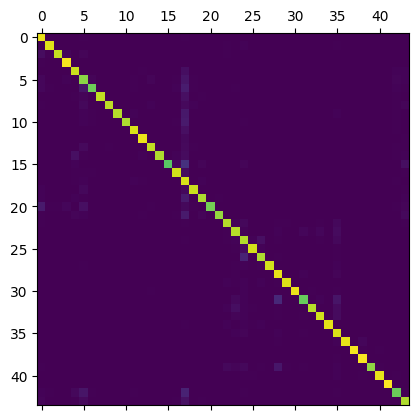

In [6]:
directory = f"{BERTAX_MODELS}phylum_mamba_residual/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierResidual(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_3_epoch.pt2"))
train_classifier(classifier, directory, (4, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.13. Mamba 2-mer

In [4]:
directory = f"{BERTAX_MODELS}mamba_2mer/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=16,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_pairs,
    True
)
# train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
classifier.model.load_state_dict(load(f"{directory}/weights_8_epoch.pt2"))
test_speed(classifier, 200)
# models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of parameters: 491_693


  1%|          | 199/20040 [01:00<1:40:00,  3.31it/s]

Average time for 200 steps: 0.3009234321117401.


#### 1.3.2.14. CLS Token-Based Transformer

Number of parameters: 913_069
Epoch 3


 16%|█▌        | 5000/31944 [15:17<1:22:39,  5.43it/s]

Halting evaluation after 82560 data points.
Halting evaluation after 82816 data points.


 16%|█▌        | 5001/31944 [16:59<229:52:42, 30.72s/it]

Halting evaluation after 66688 data points.
1/1 F1: [0.81144, 0.70583]. Precision: [0.82, 0.72989] 
Training loss: 312.73677. Validation loss: 311.97102. Patience: 200


 31%|███▏      | 10000/31944 [32:21<1:07:23,  5.43it/s] 

Halting evaluation after 82816 data points.
Halting evaluation after 82432 data points.


 31%|███▏      | 10001/31944 [34:02<186:46:45, 30.64s/it]

Halting evaluation after 66688 data points.
1/1 F1: [0.81433, 0.7067]. Precision: [0.83897, 0.74465] 
Training loss: 310.32608. Validation loss: 312.62409. Patience: 199


 47%|████▋     | 15000/31944 [49:26<52:05,  5.42it/s]    

Halting evaluation after 82816 data points.
Halting evaluation after 82432 data points.


 47%|████▋     | 15001/31944 [51:08<144:12:13, 30.64s/it]

Halting evaluation after 66688 data points.
1/1 F1: [0.81091, 0.70551]. Precision: [0.8253, 0.73441] 
Training loss: 307.73430. Validation loss: 314.08323. Patience: 198


 63%|██████▎   | 20000/31944 [1:06:29<36:38,  5.43it/s]  

Halting evaluation after 82944 data points.
Halting evaluation after 82688 data points.


 63%|██████▎   | 20001/31944 [1:08:11<101:56:11, 30.73s/it]

Halting evaluation after 66816 data points.
1/1 F1: [0.8114, 0.71208]. Precision: [0.8172, 0.73604] 
Training loss: 306.19586. Validation loss: 309.32673. Patience: 198


 78%|███████▊  | 25000/31944 [1:23:45<21:48,  5.31it/s]    

Halting evaluation after 80896 data points.
Halting evaluation after 80384 data points.


 78%|███████▊  | 25001/31944 [1:25:27<59:10:09, 30.68s/it]

Halting evaluation after 66816 data points.
1/1 F1: [0.81904, 0.70948]. Precision: [0.83463, 0.73872] 
Training loss: 303.81570. Validation loss: 306.49306. Patience: 198


 94%|█████████▍| 30000/31944 [1:40:56<06:00,  5.39it/s]   

Halting evaluation after 81280 data points.
Halting evaluation after 82176 data points.


 94%|█████████▍| 30001/31944 [1:42:38<16:32:48, 30.66s/it]

Halting evaluation after 66688 data points.
1/1 F1: [0.81638, 0.71726]. Precision: [0.833, 0.7465] 
Training loss: 301.25795. Validation loss: 297.85094. Patience: 198


100%|██████████| 31944/31944 [1:48:38<00:00,  4.90it/s]   


Training loss: 301.25795. Validation loss: 297.85094. Patience: 198
Maximum number of epochs reached; stopping early.
Training losses: [312.7367674022913, 310.32608362734317, 307.73429637551305, 306.1958588697016, 303.8156973592937, 301.25795347765086]
Validation losses: [311.97102296375266, 312.62408950564503, 314.083234719832, 309.3267265578796, 306.49305691664244, 297.85094393735426]
F1 scores: [array([0.81143999, 0.81433426, 0.81091039, 0.81140029, 0.81904289,
       0.8163836 ]), array([0.70582878, 0.70669916, 0.70550951, 0.71207947, 0.70948283,
       0.71725675])]
Precisions: [array([0.82000057, 0.83897026, 0.82529731, 0.81719567, 0.83463028,
       0.83299991]), array([0.7298853 , 0.74465111, 0.73440596, 0.7360397 , 0.73872284,
       0.74649899])]
Training losses: [312.7367674022913, 310.32608362734317, 307.73429637551305, 306.1958588697016, 303.8156973592937, 301.25795347765086]
Validation losses: [311.97102296375266, 312.62408950564503, 314.083234719832, 309.3267265578796, 3

100%|██████████| 688/688 [00:32<00:00, 21.06it/s]


F1 score: [np.float64(0.8096957815408361), np.float64(0.7152672360283334)]
Macro precision score: [np.float64(0.8207137732757968), np.float64(0.7782344711749228)]


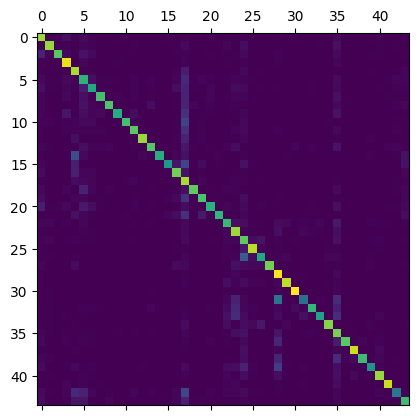

In [5]:
directory = f"{BERTAX_MODELS}phylum_transformer_token/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_tetramers,
    True
)
# test_speed(classifier, 200)
classifier.model.load_state_dict(load(f"{directory}/weights_2_epoch.pt2"))
train_classifier(classifier, directory, (3, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.15. Pretrained CLS Token-Based Transformer

In [ ]:
from stelaro.models import transformer
directory = f"{BERTAX_MODELS}transformer_token_pretrained/"
mkdir(directory)

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_tetramers,
    True
)
pretrain(classifier, directory, 20_000, pretraining_data)
# classifier.model.load_state_dict(load(f"{directory}/pretrain_mlm_weights_20k_steps.pt2"))
train_classifier(classifier, directory, (1, 2, 3, 4, 5, 6, 7, 8), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.16. CNN Transformer

Number of parameters: 1_033_005
Epoch 4


 16%|█▌        | 5000/31944 [16:04<1:27:38,  5.12it/s]

Halting evaluation after 73728 data points.
Halting evaluation after 76160 data points.


 16%|█▌        | 5001/31944 [17:45<227:44:54, 30.43s/it]

Halting evaluation after 62336 data points.
1/1 F1: [0.92106, 0.86769]. Precision: [0.92648, 0.87362] 
Training loss: 134.71387. Validation loss: 140.72226. Patience: 200


 31%|███▏      | 10000/31944 [33:56<1:11:17,  5.13it/s] 

Halting evaluation after 76288 data points.
Halting evaluation after 76416 data points.


 31%|███▏      | 10001/31944 [35:36<184:22:24, 30.25s/it]

Halting evaluation after 62208 data points.
1/1 F1: [0.92253, 0.8729]. Precision: [0.93203, 0.88252] 
Training loss: 134.84807. Validation loss: 138.80265. Patience: 200


 47%|████▋     | 15000/31944 [51:57<56:18,  5.02it/s]    

Halting evaluation after 75392 data points.
Halting evaluation after 75008 data points.


 47%|████▋     | 15001/31944 [53:39<143:37:16, 30.52s/it]

Halting evaluation after 61952 data points.
1/1 F1: [0.92746, 0.88019]. Precision: [0.93944, 0.88727] 
Training loss: 133.90444. Validation loss: 136.08479. Patience: 200


 63%|██████▎   | 20000/31944 [1:10:03<38:55,  5.11it/s]  

Halting evaluation after 76288 data points.
Halting evaluation after 75776 data points.


 63%|██████▎   | 20001/31944 [1:11:44<101:01:34, 30.45s/it]

Halting evaluation after 62080 data points.
1/1 F1: [0.91791, 0.8682]. Precision: [0.91769, 0.88648] 
Training loss: 133.24347. Validation loss: 138.25844. Patience: 199


 78%|███████▊  | 25000/31944 [1:28:01<22:43,  5.09it/s]    

Halting evaluation after 75264 data points.
Halting evaluation after 75776 data points.


 78%|███████▊  | 25001/31944 [1:29:42<58:43:25, 30.45s/it]

Halting evaluation after 62080 data points.
1/1 F1: [0.92186, 0.8744]. Precision: [0.92218, 0.87492] 
Training loss: 131.72831. Validation loss: 135.31866. Patience: 199


 94%|█████████▍| 30000/31944 [1:46:06<06:23,  5.08it/s]   

Halting evaluation after 76160 data points.
Halting evaluation after 75776 data points.


 94%|█████████▍| 30001/31944 [1:47:47<16:30:40, 30.59s/it]

Halting evaluation after 62208 data points.
1/1 F1: [0.92632, 0.86913]. Precision: [0.9279, 0.87294] 
Training loss: 130.88880. Validation loss: 133.93286. Patience: 199


100%|██████████| 31944/31944 [1:54:07<00:00,  4.67it/s]   


Training loss: 130.88880. Validation loss: 133.93286. Patience: 199
Maximum number of epochs reached; stopping early.
Training losses: [134.71387114450334, 134.84806519970297, 133.9044351350516, 133.24347221441568, 131.7283083776012, 130.88880135677755]
Validation losses: [140.7222590147225, 138.80265049958302, 136.08479312013003, 138.25843931012548, 135.3186644402515, 133.9328590389571]
F1 scores: [array([0.92105631, 0.92252761, 0.92745975, 0.9179124 , 0.92186074,
       0.92631903]), array([0.86768586, 0.87290407, 0.88019428, 0.86820424, 0.87439772,
       0.86912797])]
Precisions: [array([0.92648462, 0.93203356, 0.93943795, 0.91769451, 0.92218412,
       0.92790471]), array([0.87361716, 0.88251736, 0.88727232, 0.88647771, 0.87492363,
       0.87294127])]
Training losses: [134.71387114450334, 134.84806519970297, 133.9044351350516, 133.24347221441568, 131.7283083776012, 130.88880135677755]
Validation losses: [140.7222590147225, 138.80265049958302, 136.08479312013003, 138.2584393101254

100%|██████████| 688/688 [00:34<00:00, 19.95it/s]


F1 score: [np.float64(0.9209993920413695), np.float64(0.8817732183616137)]
Macro precision score: [np.float64(0.9134387774733108), np.float64(0.8953986962416978)]


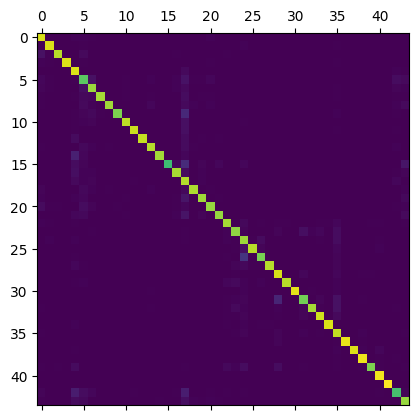

In [9]:
from stelaro.models import transformer
directory = f"{BERTAX_MODELS}phylum_transformer_token_cnn/"
mkdir(directory)

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifierCNN(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_channels,
    True
)
# test_speed(classifier, 200)
classifier.model.load_state_dict(load(f"{directory}weights_3_epoch.pt2"))
train_classifier(classifier, directory, (4, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

# 2. Long Sequence (5000 nt) Original Dataset

This section validates metagenomic classification models with an original synthetic read dataset
generated from RefSeq, an NCBI genome database, and GTDB, a phylogenomic database.

In [1]:
print("Defining values to parametrize the rest of the section.")

# Directory in which all data are to be written.
DATA_DIRECTORY = "../data/"

# Directory in which NCBI files summarizing the composition of RefSeq are to be stored.
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"

# Directories in which taxonomy files are to be installed.
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
TAXONOMY_DIRECTORY = DATA_DIRECTORY + "gtdb/"

# Number of reference genomes for each taxon to classify.
N_REFERENCE_GENOMES_PER_TAXON = 10

# Number of reference genomes for each taxon in the test set.
N_REFERENCE_GENOMES_TEST_SET = 4

# Number of synthetic samples in each reference genome.
N_READS_PER_REFERENCE_GENOME = 1000

# Proportion of reads used for the validation set.
VALIDATION_READ_PROPORTION = 0.05

# Length of the synthetic reads.
READ_LENGTH = 5000

# Name of the directory containing the original dataset.
LONG_READ_CLASSIFICATION_DIRECTORY = DATA_DIRECTORY + "long_dataset/"

# File containing the list of RefSeq reference genomes used to create synthetic reads.
GENOME_INDEX_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "index.tsv"

# File containing the initial binning of reference genomes.
GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "bin.json"
TEST_GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "test_bin.json"
NON_TEST_GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "non_test_bin.json"

# File containing a dictionary that maps indices to taxa.
MAPPING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "mapping.json"

# Directory to store raw NCBI reference genome data.
RAW_GENOME_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "raw_data/"

# Processed data directories.
TEST_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "test/"
NON_TEST_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "non_test/"
TRAINING_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "train/"
VALIDATION_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "validate/"

# Directories to store processed data.
TRAINED_MODELS = "trained_models/"
LONG_TRAINED_MODELS = "trained_models/long/"

Defining values to parametrize the rest of the section.


In [2]:
print("Importing modules and defining utility functions.")
import os
import json
import numpy as np
from stelaro.data import (
    ncbi,
    Taxonomy,
    gtdb,
    format,
    synthetic,
    get_urls,
    make_index_file,
)


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


def rename(original: str, new: str) -> None:
    os.rename(original, new)

Importing modules and defining utility functions.


In [10]:
print("Configuring the environment.")
mkdir(DATA_DIRECTORY)
mkdir(LONG_READ_CLASSIFICATION_DIRECTORY)
mkdir(TEST_DIRECTORY)
mkdir(TRAINING_DIRECTORY)
mkdir(VALIDATION_DIRECTORY)
mkdir(TRAINED_MODELS)
mkdir(LONG_TRAINED_MODELS)
mkdir(RAW_GENOME_DIRECTORY)
mkdir(NON_TEST_DIRECTORY)

Configuring the environment.


## 2.1. Prepare Data

### 2.1.1. Download Reference Genomes

In [ ]:
mkdir(SUMMARY_DIRECTORY)
ncbi.install_summaries(SUMMARY_DIRECTORY)
ncbi.summarize_assemblies(SUMMARY_DIRECTORY)

archaea: 2 579 genomes
bacteria: 432 090 genomes
fungi: 644 genomes
invertebrate: 434 genomes
plant: 186 genomes
protozoa: 121 genomes
vertebrate mammalian: 239 genomes
vertebrate other: 432 genomes
viral: 14 997 genomes

Total: 451 722


In [7]:
gtdb.install_taxonomy(TAXONOMY_DIRECTORY)

In [8]:
with open(TAXONOMY_DIRECTORY + "/bac120_taxonomy.tsv") as f:
    count = 0
    print("First lines contained in the GTDB bacterial taxonomy file:\n\n```")
    for line in f:
        if count < 5:
            print(line[:-1])
        count += 1
    print(f"```\n\nTotal number of lines: {count}.")

First lines contained in the GTDB bacterial taxonomy file:

```
RS_GCF_009898805.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_024700115.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_003829795.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_900480365.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
GB_GCA_003592305.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
```

Total number of lines: 715230.


The first column is the identifier of a reference genome. The second column is its taxonomy. Each
field of that column contains a prefix that indicates the taxonomic order:

- `d__`: Domain
- `p__`: Phylum
- `c__`: Class
- `o__`: Order
- `f__`: Family
- `g__`: Genus
- `s__`: Species

There are multiple *Escherichia coli* reference genomes because they correspond to different strains
within the same species.

We filter out taxonony identifiers to preserve only those that correspond to RefSeq reference
genomes.

In [ ]:
T = Taxonomy(("refseq", ))
urls = get_urls(SUMMARY_DIRECTORY)
T.read_GTDB_file(TAXONOMY_DIRECTORY + "/bac120_taxonomy.tsv", urls)
T.read_GTDB_file(TAXONOMY_DIRECTORY + "/ar53_taxonomy.tsv", urls)
del urls

In [ ]:
dataset = T.bin_genomes(
    depth=4,  # The dataset will have a resolution at the level of orders.
    granularity_level=0,  # Data points will be split by species.
    min_granularity=N_REFERENCE_GENOMES_PER_TAXON,  # The minimum number of species by bin.
    n_min_reference_genomes_per_bin=N_REFERENCE_GENOMES_PER_TAXON,  # Minimum number of reference genomes by species.
    n_max_reference_genomes_per_species=1,  # Maximum number of reference genomes for a species.
    max_bin_size=1,  # Maximum number of reference genomes by genus.
    n_max_bins=10  # Maximum number of data points for each class.
)

with open(GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(dataset, indent=4))

# Convert the dataset into a list of URLs that can be downloaded.
with open(GENOME_BINNING_FILE, "r") as f:
    dataset = json.load(f)
make_index_file(dataset, GENOME_INDEX_FILE, SUMMARY_DIRECTORY)

In [ ]:
mapping = {}
for i in range(len(dataset)):
    mapping[str(i)] = dataset[i][0]

with open(MAPPING_FILE, "w") as file:
    file.write(json.dumps(mapping, indent=4))

In [ ]:
ncbi.install_genomes(RAW_GENOME_DIRECTORY, GENOME_INDEX_FILE)
# Or use the command line: `../../stelarilo install-genomes --input index.tsv --dst raw_data/`

In [ ]:
from random import shuffle

with open(GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

test, non_test = [], []
for taxonomy, bins in dataset:
    elements = bins.copy()
    shuffle(elements)
    n = len(elements)
    test.append([taxonomy, elements[:N_REFERENCE_GENOMES_TEST_SET]])
    non_test.append([taxonomy, elements[N_REFERENCE_GENOMES_TEST_SET:]])

with open(TEST_GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(test, indent=4))
with open(NON_TEST_GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(non_test, indent=4))

### 2.1.2. Generate Synthetic Reads for the Test Set

In [ ]:
with open(MAPPING_FILE, "r") as file:
    mapping = json.load(file)

with open(TEST_GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

index_to_n_passes = {}
for i in mapping:
    index_to_n_passes[i] = int(N_READS_PER_REFERENCE_GENOME * 1.1)
n = synthetic.write(
    dataset,
    mapping,
    index_to_n_passes,
    RAW_GENOME_DIRECTORY,
    READ_LENGTH,
    TEST_DIRECTORY,
    TEST_DIRECTORY + "reads.fasta"
)
print(f"Sampled {n} reads.")

Estimated file size: 3498.0 MB.
Average number of reads per bin: 4400.00


  6%|▌         | 42580/699600 [00:20<09:32, 1148.52it/s]

Error on GCF_036802725.1: Could not generate an acceptable read.


 14%|█▍        | 98807/699600 [00:53<04:08, 2414.50it/s]

Error on GCF_024197615.1: 'M'


 16%|█▋        | 115370/699600 [01:04<06:24, 1518.41it/s]

Error on GCF_000255705.1: Could not generate an acceptable read.


 21%|██▏       | 149264/699600 [01:28<03:04, 2988.36it/s]

Error on GCF_000714715.1: 'R'


 29%|██▊       | 199941/699600 [01:53<02:37, 3165.01it/s]

Error on GCF_029582805.1: 'R'


 32%|███▏      | 224792/699600 [02:07<05:15, 1507.23it/s]

Error on GCF_011682235.2: 'Y'


 34%|███▍      | 239646/699600 [02:13<02:34, 2982.14it/s]

Error on GCF_001746205.1: 'W'


 34%|███▍      | 241359/699600 [02:14<03:22, 2263.03it/s]

Error on GCF_009755975.1: 'K'


 64%|██████▍   | 450339/699600 [04:14<02:23, 1735.29it/s]

Error on GCF_002243385.1: Could not generate an acceptable read.


 72%|███████▏  | 503599/699600 [04:45<01:35, 2058.86it/s]

Error on GCF_016019935.1: 'W'


 72%|███████▏  | 504808/699600 [04:46<01:26, 2254.22it/s]

Error on GCF_036553665.1: 'Y'


 79%|███████▉  | 555316/699600 [05:15<01:06, 2158.40it/s]

Error on GCF_000510265.1: 'M'


 92%|█████████▏| 643357/699600 [06:05<00:26, 2107.43it/s]

Error on GCF_002414625.1: Could not generate an acceptable read.


 94%|█████████▍| 658533/699600 [06:14<00:16, 2434.65it/s]

The file ../data/long_dataset/raw_data/GCF_964212645.1.fna does not exist


 96%|█████████▋| 673970/699600 [06:22<00:10, 2385.31it/s]

Error on GCF_013464105.1: 'W'


100%|█████████▉| 698500/699600 [06:36<00:00, 1759.71it/s]


Sampled 698500 reads.


In [4]:
rename(TEST_DIRECTORY + "y.npy", TEST_DIRECTORY + "original_y.npy")
rename(TEST_DIRECTORY + "x.npy", TEST_DIRECTORY + "original_x.npy")

In [ ]:
y = np.load(TEST_DIRECTORY + "original_y.npy")
x = np.load(TEST_DIRECTORY + "original_x.npy")
sub_x, sub_y = synthetic.sample_per_class(x, y, N_READS_PER_REFERENCE_GENOME)
print("Sampled reads")
np.save(TEST_DIRECTORY + "y.npy", sub_y)
tetramer_x = synthetic.to_tetramers(sub_x)
np.save(TEST_DIRECTORY + "x.npy", tetramer_x)

Sampled reads


159000it [02:12, 1200.29it/s]


### 2.1.3. Generate Synthetic Reads for the Other Sets

In [ ]:
with open(MAPPING_FILE, "r") as file:
    mapping = json.load(file)

with open(NON_TEST_GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

index_to_n_passes = {}
for i in mapping:
    index_to_n_passes[i] = N_READS_PER_REFERENCE_GENOME
n = synthetic.write(
    dataset,
    mapping,
    index_to_n_passes,
    RAW_GENOME_DIRECTORY,
    READ_LENGTH,
    NON_TEST_DIRECTORY,
    NON_TEST_DIRECTORY + "reads.fasta"
)
print(f"Sampled {n} reads.")

Estimated file size: 4770.0 MB.
Average number of reads per bin: 6000.00


  2%|▏         | 16934/954000 [00:07<04:18, 3631.76it/s]

Error on GCF_011319475.1: Could not generate an acceptable read.


 11%|█         | 106947/954000 [00:55<04:49, 2926.67it/s]

Error on GCF_000348725.1: 'Y'


 16%|█▌        | 149369/954000 [01:18<05:06, 2623.26it/s]

Error on GCF_000021565.1: 'W'


 26%|██▌       | 245417/954000 [02:21<04:44, 2487.88it/s]

Error on GCF_000008565.1: 'S'


 28%|██▊       | 264379/954000 [02:34<09:48, 1172.57it/s]

Error on GCF_002251945.1: 'R'


 31%|███       | 294397/954000 [02:51<06:58, 1576.00it/s]

Error on GCF_000006985.1: 'Y'


 34%|███▍      | 328752/954000 [03:07<03:29, 2989.33it/s]

Error on GCF_002379365.1: Could not generate an acceptable read.


 38%|███▊      | 362385/954000 [03:25<04:37, 2129.48it/s]

Error on GCF_010470665.1: 'R'


 85%|████████▌ | 811373/954000 [07:43<01:11, 1983.31it/s]

Error on GCF_029169405.1: Could not generate an acceptable read.


100%|██████████| 954000/954000 [09:04<00:00, 1751.63it/s]


Sampled 954000 reads.


In [4]:
rename(NON_TEST_DIRECTORY + "y.npy", NON_TEST_DIRECTORY + "original_y.npy")
rename(NON_TEST_DIRECTORY + "x.npy", NON_TEST_DIRECTORY + "original_x.npy")

In [5]:
# Compress the dataset
x = np.load(NON_TEST_DIRECTORY + "original_x.npy")
tetramer_x = synthetic.to_tetramers(x)
np.save(NON_TEST_DIRECTORY + "original_x_tetramers.npy", tetramer_x)

954000it [13:34, 1170.59it/s]


In [11]:
x = np.load(NON_TEST_DIRECTORY + "original_x_tetramers.npy")
y = np.load(NON_TEST_DIRECTORY + "original_y.npy")
n_references = N_REFERENCE_GENOMES_PER_TAXON - N_REFERENCE_GENOMES_TEST_SET
total = N_READS_PER_REFERENCE_GENOME * n_references
n_validation_reads = int(total * VALIDATION_READ_PROPORTION)
n_train_reads = int(total * (1.0 - VALIDATION_READ_PROPORTION))
train, validate = synthetic.divide_dataset(x, y, (n_train_reads, n_validation_reads))
np.save(f"{TRAINING_DIRECTORY}x.npy", train[0])
np.save(f"{TRAINING_DIRECTORY}y.npy", train[1])
np.save(f"{VALIDATION_DIRECTORY}x.npy", validate[0])
np.save(f"{VALIDATION_DIRECTORY}y.npy", validate[1])

## 2.2. Validate Data

## 2.3. Train Classification Models

### 2.3.1. Load Data

In [3]:
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
from stelaro import models
from torch import save, load, nn
import time

BATCH_SIZE = 64


def get_data():
    train_data = DataLoader(
        models.SyntheticTetramerDataset(TRAINING_DIRECTORY),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    validation_data = DataLoader(
        models.SyntheticTetramerDataset(VALIDATION_DIRECTORY),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    test_data = DataLoader(
        models.SyntheticTetramerDataset(TEST_DIRECTORY),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    with open(MAPPING_FILE, "r") as f:
        mapping = json.load(f)
    return train_data, validation_data, test_data, mapping


def train_classifier(
        classifier, cache_directory: str, epochs: tuple[int], train_data, validation_data
    ) -> None:
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    losses, validation_losses, f1, p = [], [], [], []
    for epoch in epochs:
        print(f"Epoch {epoch}")
        losses_, validation_losses_, f1_, p_ = classifier.train(
            train_data,
            validation_data,
            optimizer,
            max_n_epochs=1,
            patience=200,
            loss_function=nn.CrossEntropyLoss(),
            loss_function_type="supervised",
            evaluation_interval=4000,
            evaluation_maximum_duration=30.0,
            patience_interval=4000,
            n_max_steps=30_000
        )
        print(f"Training losses: {losses_}")
        print(f"Validation losses: {validation_losses_}")
        print(f"F1 scores: {f1_}")
        print(f"Precisions: {p_}")
        losses += losses_
        validation_losses += validation_losses_
        f1 += f1_
        p += p_
        save(classifier.model.state_dict(), f"{cache_directory}weights_{epoch}_epoch.pt2")

    print(f"Training losses: {losses}")
    print(f"Validation losses: {validation_losses}")
    print(f"F1 scores: {f1}")
    print(f"Precisions: {p}")


def test_speed(classifier, N):
    parameters = classifier.get_parameters()
    total_params = sum(param.numel() for param in parameters)
    print(f"Number of parameters: {total_params:_}")
    optimizer = Adam(classifier.get_parameters(), lr=0.001)
    a = time.time()
    classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=N * 2,
        evaluation_maximum_duration=30.0,
        patience_interval=N * 2,
        n_max_steps=N
    )
    delta = time.time() - a
    average = delta / N
    print(f"Average time for {N} steps: {average}.")


train_data, validation_data, test_data, mapping = get_data()

### 2.3.2. Train Classification Models

#### 2.3.2.1. Mamba

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba/"
mkdir(directory)
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_8_epoch.pt2"))
train_classifier(classifier, directory, (9, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 400)

#### 2.3.2.2. Mamba-Memory

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba_memory/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_8_epoch.pt2"))
train_classifier(classifier, directory, (9, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 400)

#### 2.2.2.3. Mamba-CNN

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba_cnn/"
mkdir(directory)
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_7_epoch.pt2"))
train_classifier(classifier, directory, (8, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 400)

#### 2.2.2.4. Mamba-Memory-CNN

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba_memory_cnn/"
mkdir(directory)
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierMemoryCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_7_epoch.pt2"))
train_classifier(classifier, directory, (8, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 400)

#### 2.2.2.5. Transformer

In [ ]:
directory = f"{LONG_TRAINED_MODELS}transformer/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token",
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}weights_7_epoch.pt2"))
train_classifier(classifier, directory, (8, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 30)

#### 2.2.2.6. Transformer-CNN

In [ ]:
directory = f"{LONG_TRAINED_MODELS}transformer_cnn/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer


classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifierCNN(
        N=READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
        classification_type="token"
    ),
    format.to_channels,
    True
)

classifier.model.load_state_dict(load(f"{directory}weights_7_epoch.pt2"))
train_classifier(classifier, directory, (8, ), train_data, validation_data)
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 400)

## 2.4. Kraken 2

Kraken 2 supports NCBI taxonomy out-of-the-box (with the command
`kraken2-build --download-taxonomy --db $DB`), but the dataset that we use in this section was
elaborated from GTDB, which uses a different phylogenomy. We thus need to create a custom taxonomy
to execute Kraken 2. This custom taxonomy must contain two files:

- `nodes.dmp` contains 3 fields on each line:
  - Taxonomic identifier (unique)
  - Taxonomic identifier of the parent (not necessarily unique)
  - Taxonomic rank
- `names.dmp` contains 2 fields on each line:
  - Taxonomic identifier (unique)
  - Name associated to the taxonomic identifier

The cells below create the files required for Kraken 2 to operate properly.

In [ ]:
def create_kraken2_taxonomy_from_gtdb(
        bin_file: str,
        nodes_filename: str,
        names_filename: str,
        acc_to_taxid: str,
    ) -> dict:
    """Create node and name files for kraken2 based on bins created from the
    GTDB database.

    Args:
        bin_file: Binning file created by `stelaro.data.Taxonomy.bin_genomes`
            from the GTDB taxonomy. File used as an input.
        nodes_filename: Name of the output file containing nodes. Each line
            is formatted as: `taxid\t|\tparent_taxid\t|\trank\t|`.
        names_filename: Name of the output file containing names. Each line
            is formatted as: `taxid\t|\tname\t|\t|\tscientific name\t|`.
        acc_to_taxid: Name of the output file containing a map from reference
            genome accession number to taxonomy ID. Each line is formatted as:
            `accession_number\ttaxid`.
    """
    with open(bin_file, "r") as f:
        bins = json.load(f)
    # Retrieve all nodes.
    taxonomies = []
    for bin in bins:
        higher_levels = bin[0]  # domain to order
        for species in bin[1]:
            name, _ = species
            taxonomies.append(higher_levels + [name])
    nodes = []
    for depth in range(1, len(taxonomies[0]) + 1):
        for taxon in taxonomies:
            value = taxon[:depth]
            if value not in nodes:
                nodes.append(value)
    # Assign unique taxonomic IDs.
    name_to_taxid = {"root": 1}
    taxid_to_rank = {1: "no rank"}
    for node in nodes:
        name = node[-1]
        if name in name_to_taxid:
            raise RuntimeError(f"Name {name} is repeated.")
        taxid = len(name_to_taxid) + 1  # 1 is reserved for root.
        name_to_taxid[name] = taxid
        taxid_to_rank[taxid] = ("root", "domain", "phylum", "class", "order", "species")[len(node)]
    # Resolve parents.
    taxid_to_parent_taxid = {1: 1}
    for node in nodes:
        name = node[-1]
        taxid = name_to_taxid[name]
        if len(node) == 1:
            taxid_to_parent_taxid[taxid] = 1
        else:
            parent_name = node[-2]
            taxid_to_parent_taxid[taxid] = name_to_taxid[parent_name]
    # Determine the taxonomic ID of each reference genome.
    accession_to_taxid = {}
    for bin in bins:
        for species in bin[1]:
            name, reference_genomes = species
            taxid = name_to_taxid[name]
            for reference_genome in reference_genomes:
                accession_to_taxid[reference_genome] = taxid

    with open(nodes_filename, "w") as fnodes:
        for child, parent in taxid_to_parent_taxid.items():
            fnodes.write(f"{child}\t|\t{parent}\t|\t{taxid_to_rank[child]}\t|\n")

    with open(names_filename, "w") as fnames:
        for name, taxid in name_to_taxid.items():
            fnames.write(f"{taxid}\t|\t{name}\t|\t|\tscientific name\t|\n")

    with open(acc_to_taxid, "w") as fmap:
        for acc, taxid in accession_to_taxid.items():
            fmap.write(f"{acc}\t{taxid}\n")


create_kraken2_taxonomy_from_gtdb(
    GENOME_BINNING_FILE,
    LONG_READ_CLASSIFICATION_DIRECTORY + "nodes.dmp",
    LONG_READ_CLASSIFICATION_DIRECTORY + "names.dmp",
    LONG_READ_CLASSIFICATION_DIRECTORY + "kraken2_acc2taxid.tsv",
)

In [ ]:
def load_acc2taxid(path: str):
    acc2taxid = {}
    with open(path, "r") as f:
        for line in f:
            elements = line.rstrip().split("\t")
            acc = elements[0]
            if acc in acc2taxid:
                raise RuntimeError("Duplicate ID.")
            taxid = elements[1]
            acc2taxid[acc] = taxid
    return acc2taxid


def rewrite_fasta(in_fasta, out_fasta, acc2taxid):
    with open(in_fasta, "r") as fin, open(out_fasta, "w") as fout:
        for line in fin:
            if line.startswith(">"):
                parts = line[1:].strip().split()
                if len(parts) < 4:
                    raise ValueError(
                        f"Invalid FASTA header (expected 4 fields): {line.strip()}"
                    )
                unique_id, genome_id, block_id, offset = parts[:4]
                try:
                    taxid = acc2taxid[genome_id]
                except KeyError:
                    raise KeyError(
                        f"No taxid found for genome accession: {genome_id}"
                    )
                new_header = (
                    f">{unique_id}|kraken:taxid|{taxid} "
                    f"{genome_id} {block_id} {offset}\n"
                )
                fout.write(new_header)
            else:
                fout.write(line)

In [ ]:
acc2taxid = load_acc2taxid(LONG_READ_CLASSIFICATION_DIRECTORY + "kraken2_acc2taxid.tsv")
rewrite_fasta(TEST_DIRECTORY + "reads.fasta", TEST_DIRECTORY + "reads_kraken2_gtdb.fasta", acc2taxid)
rewrite_fasta(NON_TEST_DIRECTORY + "reads.fasta", NON_TEST_DIRECTORY + "reads_kraken2_gtdb.fasta", acc2taxid)

We now have everything need to run Kraken 2. Execute the following:

```
# Prepare the reference database.
mkdir kraken2_gtdb
mkdir kraken2_gtdb/taxonomy
cp ../data/long_dataset/names.dmp kraken2_gtdb/taxonomy/names.dmp
cp ../data/long_dataset/nodes.dmp kraken2_gtdb/taxonomy/nodes.dmp

# Add reference reads to the database.
kraken2-build --add-to-library ../data/long_dataset/non_test/reads_kraken2_gtdb.fasta --db kraken2_gtdb

# Build the database.
kraken2-build --build --db kraken2_gtdb

# Classify reads.
kraken2 --db kraken2_gtdb ../data/long_dataset/test/reads_kraken2_gtdb.fasta --output kraken_gtdb.out
```

Now, the file `kraken_gtdb.out` contains predicted classes. We can test the performance of Kraken 2
by comparing the classified labels with the real ones:

In [ ]:
from stelaro import models
from random import choice, randint
import numpy as np


FILE = "kraken_gtdb.out"


with open(MAPPING_FILE, "r") as f:
    mapping = json.load(f)
mappings = models.obtain_rank_based_mappings(mapping)
order_to_label = {}
for i, names in mapping.items():
    order_to_label[names[-1]] = int(i)


def define_labels(level):
    labels = {}
    n = 0
    for _, names in mapping.items():
        name = names[level]
        if name not in labels:
            labels[name] = []
        labels[name].append(n)
        n += 1
    return labels


class_to_labels = define_labels(2)
phylum_to_labels = define_labels(1)
domain_to_labels = define_labels(0)

taxid_to_parent = {}
taxid_to_rank = {}
with open(LONG_READ_CLASSIFICATION_DIRECTORY + "nodes.dmp", "r") as f:
    for line in f:
        elements = line.strip().split("\t")
        child = elements[0]
        parent = elements[2]
        rank = elements[4]
        taxid_to_parent[child] = parent
        taxid_to_rank[child] = rank
taxid_to_names = {}
with open(LONG_READ_CLASSIFICATION_DIRECTORY + "names.dmp", "r") as f:
    for line in f:
        elements = line.strip().split("\t")
        taxid = elements[0]
        name = elements[2]
        taxid_to_names[taxid] = name


def get_predicted_label_from_taxid(taxid) -> int:
    rank = taxid_to_rank[taxid]
    name = taxid_to_names[taxid]
    if rank == "no rank":
        return None
    elif rank == "species":
        order_taxid = taxid_to_parent[taxid]
        order = taxid_to_names[order_taxid]
        return order_to_label[order]
    elif rank == "order":
        return order_to_label[name]
    elif rank == "class":
        return choice(class_to_labels[name])
    elif rank == "phylum":
        return choice(phylum_to_labels[name])
    elif rank == "domain":
        return choice(domain_to_labels[name])
    raise RuntimeError(f"{taxid}, {name}, {rank}")


unclassified = 0
classified = 0
predicted_y = []
real_y = []
with open(FILE, "r") as f:
    for line in f:
        elements = line.split("\t")
        # Real
        target = elements[1].split("|")[-1]
        order_taxid = taxid_to_parent[target]
        target_name = taxid_to_names[order_taxid]
        target = order_to_label[target_name]
        real_y.append(target)
        # Predicted
        predicted_taxid = elements[2]
        if elements[0] == "U" or predicted_taxid == 0:
            unclassified += 1
            predicted_y.append(randint(0, len(mapping) - 1))
        else:
            assert predicted_taxid in taxid_to_parent, f"{predicted_taxid}"
            prediction = get_predicted_label_from_taxid(predicted_taxid)
            if prediction is None:  # predicted as root
                prediction = randint(0, len(mapping) - 1)
            predicted_y.append(prediction)
            classified += 1

print("Classified: ", classified)
print("Unclassified: ", unclassified)


def collapse(v):
    collapsed = []
    for rank in v[::-1]:
        collapsed.append(np.mean(rank))
    return collapsed


f1 = collapse(models.rank_based_f1_score(mappings, real_y, predicted_y))
print(f"F1 score: {f1}")
macro = collapse(
    models.rank_based_precision(mappings, real_y, predicted_y, "macro", False)
)
print(f"Macro precision score: {macro}")

Classified:  504933
Unclassified:  178167
F1 score: [np.float64(0.8392724370547957), np.float64(0.6052735572470833), np.float64(0.5944489386884735), np.float64(0.5191295700323759)]
Macro precision score: [np.float64(0.8500475461401579), np.float64(0.6221111013591202), np.float64(0.5990786382416311), np.float64(0.5147055749918171)]
